In [19]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import dataloader 
from tqdm import tqdm

In [20]:
class BCIDataset(Dataset):

    def __init__(self, x, y= None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]
        
    def __len__(self):
        return len(self.x)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class EEGNET(nn.Module):
    def __init__(self):
        super(EEGNET, self).__init__()

        # input [1, 2, 750]
        self.first_conv2d = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(1, 51), stride= (1, 1), padding=(0, 25), bias= False),
            nn.BatchNorm2d(4)
        )
        # [64, 2, 750]
        self.depthwise_conv2d = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size= (2, 1), stride= (1, 1), groups= 4, bias= False),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.AvgPool2d(kernel_size= (1, 4), stride= (1, 4), padding= 0),
            nn.Dropout(0.25)
        )

        self.separable_conv2d = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size= (1, 15), stride= (1, 1), padding= (0, 7), bias= False),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.AvgPool2d(kernel_size= (1, 8), stride= (1, 8), padding= 0),
            nn.Dropout(0.25)
        )

        self.fc = nn.Sequential(
            nn.Linear(184, 2)
        )

    def forward(self, x):
        x = self.first_conv2d(x)
        x = self.depthwise_conv2d(x)
        x = self.separable_conv2d(x)
        x = x.flatten(1)
        return self.fc(x)       
     

In [22]:
class DeepConvNet(nn.Module):

    def __init__(self):
        super(DeepConvNet, self).__init__()

        self.conv2d = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size= (1, 5)),
            nn.Conv2d(25, 25, kernel_size= (2, 1)),
            nn.BatchNorm2d(25),
            nn.ELU(),
            nn.MaxPool2d(kernel_size= (1, 2)),
            nn.Dropout(),
            nn.Conv2d(25, 50, kernel_size= (1, 5)),
            nn.BatchNorm2d(50),
            nn.ELU(),
            nn.MaxPool2d(kernel_size= (1, 2)),
            nn.Dropout(),
            nn.Conv2d(50, 100, kernel_size= (1, 5)),
            nn.BatchNorm2d(100),
            nn.ELU(),
            nn.MaxPool2d(kernel_size= (1, 2)),
            nn.Dropout(),
            nn.Conv2d(100, 200, kernel_size= (1, 5)),
            nn.BatchNorm2d(200),
            nn.ELU(),
            nn.MaxPool2d(kernel_size= (1, 2)),
            nn.Dropout()
        )

        self.fc = nn.Sequential(
            nn.Linear(8600, 2)
        )

    def forward(self, x):

        x = self.conv2d(x)
        x = x.flatten(1)
        return self.fc(x)


In [23]:
# hyperparameter
batch_size = 32
learning_rate = 1e-2
n_epochs = 500

In [24]:
import gc 

# load data
train_X, train_y, test_X, test_y = dataloader.read_bci_data()
print(train_X.shape, test_X.shape)

# get dataset
train_set = BCIDataset(train_X, train_y)
test_set = BCIDataset(test_X, test_y)

del train_X, train_y, test_X, test_y
gc.collect()

train_loader = DataLoader(train_set, batch_size= batch_size, shuffle= True)
test_loader = DataLoader(test_set, batch_size= batch_size, shuffle= False)

(1080, 1, 2, 750) (1080, 1, 2, 750)


In [25]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda:0


In [26]:
# model = EEGNET().to(device)
model = DeepConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [27]:
best_acc = 0
history = {"loss": [], "acc": [], "test_loss": [], "test_acc": []}

for epoch in range(n_epochs):
    
    #training
    model.train()

    batch_train_loss = []
    batch_train_acc = []

    for batch in tqdm(train_loader):

        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(features)
        loss = criterion(pred, labels.long())
        loss.backward()
        optimizer.step()

        acc = (pred.argmax(dim= -1) == labels).float().mean()

        batch_train_loss.append(loss.item())
        batch_train_acc.append(acc)


    train_loss = sum(batch_train_loss) / len(batch_train_loss)
    train_acc = sum(batch_train_acc) / len(batch_train_acc)
    history["loss"].append(train_loss)
    history["acc"].append(train_acc)

    # validation
    model.eval()
    
    batch_test_loss = []
    batch_test_acc = []

    with torch.no_grad():
        
        for batch in tqdm(test_loader):

            features, labels = batch
            labels = labels.to(device)
            test_pred = model(features.to(device))
            loss = criterion(test_pred, labels.long())
            acc = (test_pred.argmax(dim= -1) == labels).float().mean()

            batch_test_acc.append(acc)
            batch_test_loss.append(loss.item())

        test_loss = sum(batch_test_loss) / len(batch_test_loss)
        test_acc = sum(batch_test_acc) / len(batch_test_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
        
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f} [ Test | {epoch + 1:03d}/{n_epochs:03d} ] loss = {test_loss:.5f}, test_acc = {test_acc:.5f}")

    if test_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        
        torch.save(model.state_dict(), f"./best.ckpt")
        best_acc = test_acc


100%|██████████| 34/34 [00:00<00:00, 449.57it/s]


[ Train | 001/500 ] loss = 5.88008, acc = 0.57659 [ Test | 001/500 ] loss = 3.73402, test_acc = 0.62745
Best model found at epoch 0, saving model


100%|██████████| 34/34 [00:00<00:00, 398.14it/s]


[ Train | 002/500 ] loss = 3.13948, acc = 0.63450 [ Test | 002/500 ] loss = 3.29263, test_acc = 0.58395


100%|██████████| 34/34 [00:00<00:00, 355.77it/s]


[ Train | 003/500 ] loss = 2.46504, acc = 0.63848 [ Test | 003/500 ] loss = 1.89731, test_acc = 0.66238
Best model found at epoch 2, saving model


100%|██████████| 34/34 [00:00<00:00, 451.51it/s]


[ Train | 004/500 ] loss = 1.88825, acc = 0.69087 [ Test | 004/500 ] loss = 1.66476, test_acc = 0.68566
Best model found at epoch 3, saving model


100%|██████████| 34/34 [00:00<00:00, 349.59it/s]


[ Train | 005/500 ] loss = 1.83289, acc = 0.67678 [ Test | 005/500 ] loss = 2.28680, test_acc = 0.67034


100%|██████████| 34/34 [00:00<00:00, 450.08it/s]


[ Train | 006/500 ] loss = 1.68146, acc = 0.71354 [ Test | 006/500 ] loss = 1.54754, test_acc = 0.67555


100%|██████████| 34/34 [00:00<00:00, 442.96it/s]


[ Train | 007/500 ] loss = 1.51743, acc = 0.70006 [ Test | 007/500 ] loss = 1.58390, test_acc = 0.65686


100%|██████████| 34/34 [00:00<00:00, 342.57it/s]


[ Train | 008/500 ] loss = 1.39919, acc = 0.70404 [ Test | 008/500 ] loss = 1.46800, test_acc = 0.69056
Best model found at epoch 7, saving model


100%|██████████| 34/34 [00:00<00:00, 422.94it/s]


[ Train | 009/500 ] loss = 1.18595, acc = 0.72794 [ Test | 009/500 ] loss = 0.77538, test_acc = 0.73529
Best model found at epoch 8, saving model


100%|██████████| 34/34 [00:00<00:00, 441.06it/s]


[ Train | 010/500 ] loss = 1.04711, acc = 0.72733 [ Test | 010/500 ] loss = 0.97889, test_acc = 0.71415


100%|██████████| 34/34 [00:00<00:00, 428.07it/s]


[ Train | 011/500 ] loss = 1.37736, acc = 0.69945 [ Test | 011/500 ] loss = 1.02858, test_acc = 0.72335


100%|██████████| 34/34 [00:00<00:00, 421.74it/s]


[ Train | 012/500 ] loss = 0.91523, acc = 0.72886 [ Test | 012/500 ] loss = 0.85202, test_acc = 0.72426


100%|██████████| 34/34 [00:00<00:00, 444.88it/s]


[ Train | 013/500 ] loss = 0.81945, acc = 0.75797 [ Test | 013/500 ] loss = 0.70453, test_acc = 0.73131


100%|██████████| 34/34 [00:00<00:00, 389.69it/s]


[ Train | 014/500 ] loss = 0.72336, acc = 0.75214 [ Test | 014/500 ] loss = 0.64314, test_acc = 0.77053
Best model found at epoch 13, saving model


100%|██████████| 34/34 [00:00<00:00, 452.98it/s]


[ Train | 015/500 ] loss = 0.71248, acc = 0.74939 [ Test | 015/500 ] loss = 0.63845, test_acc = 0.73897


100%|██████████| 34/34 [00:00<00:00, 389.18it/s]


[ Train | 016/500 ] loss = 0.68938, acc = 0.75674 [ Test | 016/500 ] loss = 0.73779, test_acc = 0.75705


100%|██████████| 34/34 [00:00<00:00, 442.04it/s]


[ Train | 017/500 ] loss = 0.65945, acc = 0.76440 [ Test | 017/500 ] loss = 0.61855, test_acc = 0.77696
Best model found at epoch 16, saving model


100%|██████████| 34/34 [00:00<00:00, 386.45it/s]


[ Train | 018/500 ] loss = 0.60099, acc = 0.76409 [ Test | 018/500 ] loss = 0.54269, test_acc = 0.77451


100%|██████████| 34/34 [00:00<00:00, 389.41it/s]


[ Train | 019/500 ] loss = 0.66608, acc = 0.76409 [ Test | 019/500 ] loss = 0.58625, test_acc = 0.77911
Best model found at epoch 18, saving model


100%|██████████| 34/34 [00:00<00:00, 280.12it/s]


[ Train | 020/500 ] loss = 0.55389, acc = 0.76409 [ Test | 020/500 ] loss = 0.56506, test_acc = 0.77635


100%|██████████| 34/34 [00:00<00:00, 361.19it/s]


[ Train | 021/500 ] loss = 0.61254, acc = 0.77022 [ Test | 021/500 ] loss = 0.61052, test_acc = 0.76961


100%|██████████| 34/34 [00:00<00:00, 455.40it/s]


[ Train | 022/500 ] loss = 0.58392, acc = 0.76103 [ Test | 022/500 ] loss = 0.53306, test_acc = 0.79105
Best model found at epoch 21, saving model


100%|██████████| 34/34 [00:00<00:00, 447.48it/s]


[ Train | 023/500 ] loss = 0.53675, acc = 0.78002 [ Test | 023/500 ] loss = 0.62236, test_acc = 0.76134


100%|██████████| 34/34 [00:00<00:00, 362.51it/s]


[ Train | 024/500 ] loss = 0.53633, acc = 0.77114 [ Test | 024/500 ] loss = 0.53276, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 435.99it/s]


[ Train | 025/500 ] loss = 0.51592, acc = 0.79013 [ Test | 025/500 ] loss = 0.51273, test_acc = 0.79565
Best model found at epoch 24, saving model


100%|██████████| 34/34 [00:00<00:00, 431.09it/s]


[ Train | 026/500 ] loss = 0.49314, acc = 0.78585 [ Test | 026/500 ] loss = 0.50280, test_acc = 0.80668
Best model found at epoch 25, saving model


100%|██████████| 34/34 [00:00<00:00, 439.60it/s]


[ Train | 027/500 ] loss = 0.46428, acc = 0.79688 [ Test | 027/500 ] loss = 0.53535, test_acc = 0.79534


100%|██████████| 34/34 [00:00<00:00, 447.38it/s]


[ Train | 028/500 ] loss = 0.48738, acc = 0.79534 [ Test | 028/500 ] loss = 0.51997, test_acc = 0.79320


100%|██████████| 34/34 [00:00<00:00, 358.23it/s]


[ Train | 029/500 ] loss = 0.46891, acc = 0.79197 [ Test | 029/500 ] loss = 0.53319, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 446.95it/s]


[ Train | 030/500 ] loss = 0.48713, acc = 0.79197 [ Test | 030/500 ] loss = 0.51400, test_acc = 0.79075


100%|██████████| 34/34 [00:00<00:00, 369.29it/s]


[ Train | 031/500 ] loss = 0.48867, acc = 0.78738 [ Test | 031/500 ] loss = 0.53648, test_acc = 0.79350


100%|██████████| 34/34 [00:00<00:00, 394.83it/s]


[ Train | 032/500 ] loss = 0.48800, acc = 0.79688 [ Test | 032/500 ] loss = 0.57471, test_acc = 0.77635


100%|██████████| 34/34 [00:00<00:00, 396.91it/s]


[ Train | 033/500 ] loss = 0.47949, acc = 0.82292 [ Test | 033/500 ] loss = 0.55019, test_acc = 0.78585


100%|██████████| 34/34 [00:00<00:00, 439.42it/s]


[ Train | 034/500 ] loss = 0.49553, acc = 0.78401 [ Test | 034/500 ] loss = 0.51093, test_acc = 0.79412


100%|██████████| 34/34 [00:00<00:00, 371.97it/s]


[ Train | 035/500 ] loss = 0.46333, acc = 0.79749 [ Test | 035/500 ] loss = 0.50802, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 447.25it/s]


[ Train | 036/500 ] loss = 0.46975, acc = 0.79810 [ Test | 036/500 ] loss = 0.55326, test_acc = 0.76930


100%|██████████| 34/34 [00:00<00:00, 358.64it/s]


[ Train | 037/500 ] loss = 0.43523, acc = 0.81219 [ Test | 037/500 ] loss = 0.50595, test_acc = 0.79228


100%|██████████| 34/34 [00:00<00:00, 433.63it/s]


[ Train | 038/500 ] loss = 0.45694, acc = 0.81005 [ Test | 038/500 ] loss = 0.58749, test_acc = 0.75827


100%|██████████| 34/34 [00:00<00:00, 423.93it/s]


[ Train | 039/500 ] loss = 0.46401, acc = 0.79228 [ Test | 039/500 ] loss = 0.53065, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 450.75it/s]


[ Train | 040/500 ] loss = 0.44220, acc = 0.81158 [ Test | 040/500 ] loss = 0.48829, test_acc = 0.80821
Best model found at epoch 39, saving model


100%|██████████| 34/34 [00:00<00:00, 442.63it/s]


[ Train | 041/500 ] loss = 0.45741, acc = 0.78983 [ Test | 041/500 ] loss = 0.50320, test_acc = 0.79994


100%|██████████| 34/34 [00:00<00:00, 348.72it/s]


[ Train | 042/500 ] loss = 0.47230, acc = 0.80944 [ Test | 042/500 ] loss = 0.53051, test_acc = 0.77727


100%|██████████| 34/34 [00:00<00:00, 382.91it/s]


[ Train | 043/500 ] loss = 0.41077, acc = 0.81679 [ Test | 043/500 ] loss = 0.53139, test_acc = 0.78983


100%|██████████| 34/34 [00:00<00:00, 417.52it/s]


[ Train | 044/500 ] loss = 0.41023, acc = 0.82200 [ Test | 044/500 ] loss = 0.48284, test_acc = 0.80576


100%|██████████| 34/34 [00:00<00:00, 437.84it/s]


[ Train | 045/500 ] loss = 0.38215, acc = 0.83854 [ Test | 045/500 ] loss = 0.56484, test_acc = 0.77145


100%|██████████| 34/34 [00:00<00:00, 379.61it/s]


[ Train | 046/500 ] loss = 0.44602, acc = 0.82108 [ Test | 046/500 ] loss = 0.64693, test_acc = 0.74234


100%|██████████| 34/34 [00:00<00:00, 399.14it/s]


[ Train | 047/500 ] loss = 0.42503, acc = 0.80423 [ Test | 047/500 ] loss = 0.50582, test_acc = 0.80116


100%|██████████| 34/34 [00:00<00:00, 406.67it/s]


[ Train | 048/500 ] loss = 0.43879, acc = 0.82629 [ Test | 048/500 ] loss = 0.50091, test_acc = 0.80637


100%|██████████| 34/34 [00:00<00:00, 367.77it/s]


[ Train | 049/500 ] loss = 0.40257, acc = 0.82353 [ Test | 049/500 ] loss = 0.53026, test_acc = 0.78186


100%|██████████| 34/34 [00:00<00:00, 379.33it/s]


[ Train | 050/500 ] loss = 0.43381, acc = 0.81801 [ Test | 050/500 ] loss = 0.50762, test_acc = 0.80208


100%|██████████| 34/34 [00:00<00:00, 368.12it/s]


[ Train | 051/500 ] loss = 0.42440, acc = 0.83180 [ Test | 051/500 ] loss = 0.70650, test_acc = 0.72763


100%|██████████| 34/34 [00:00<00:00, 422.97it/s]


[ Train | 052/500 ] loss = 0.42984, acc = 0.81250 [ Test | 052/500 ] loss = 0.59261, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 417.01it/s]


[ Train | 053/500 ] loss = 0.45284, acc = 0.81740 [ Test | 053/500 ] loss = 0.51858, test_acc = 0.79320


100%|██████████| 34/34 [00:00<00:00, 379.36it/s]


[ Train | 054/500 ] loss = 0.41863, acc = 0.82966 [ Test | 054/500 ] loss = 0.50324, test_acc = 0.81036
Best model found at epoch 53, saving model


100%|██████████| 34/34 [00:00<00:00, 415.38it/s]


[ Train | 055/500 ] loss = 0.40905, acc = 0.83027 [ Test | 055/500 ] loss = 0.61324, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 356.32it/s]


[ Train | 056/500 ] loss = 0.40340, acc = 0.82874 [ Test | 056/500 ] loss = 0.57172, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 439.77it/s]


[ Train | 057/500 ] loss = 0.44983, acc = 0.81618 [ Test | 057/500 ] loss = 0.53224, test_acc = 0.78002


100%|██████████| 34/34 [00:00<00:00, 442.57it/s]


[ Train | 058/500 ] loss = 0.41948, acc = 0.82751 [ Test | 058/500 ] loss = 0.55385, test_acc = 0.81740
Best model found at epoch 57, saving model


100%|██████████| 34/34 [00:00<00:00, 421.52it/s]


[ Train | 059/500 ] loss = 0.38223, acc = 0.83915 [ Test | 059/500 ] loss = 0.67967, test_acc = 0.76501


100%|██████████| 34/34 [00:00<00:00, 436.43it/s]


[ Train | 060/500 ] loss = 0.44702, acc = 0.83058 [ Test | 060/500 ] loss = 0.57620, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 429.11it/s]


[ Train | 061/500 ] loss = 0.39109, acc = 0.83977 [ Test | 061/500 ] loss = 0.53275, test_acc = 0.78707


100%|██████████| 34/34 [00:00<00:00, 377.61it/s]


[ Train | 062/500 ] loss = 0.41375, acc = 0.83456 [ Test | 062/500 ] loss = 0.57819, test_acc = 0.77543


100%|██████████| 34/34 [00:00<00:00, 373.77it/s]


[ Train | 063/500 ] loss = 0.41290, acc = 0.84007 [ Test | 063/500 ] loss = 0.54910, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 427.14it/s]


[ Train | 064/500 ] loss = 0.40853, acc = 0.83762 [ Test | 064/500 ] loss = 0.62834, test_acc = 0.74357


100%|██████████| 34/34 [00:00<00:00, 353.02it/s]


[ Train | 065/500 ] loss = 0.39274, acc = 0.83487 [ Test | 065/500 ] loss = 0.57499, test_acc = 0.79442


100%|██████████| 34/34 [00:00<00:00, 444.07it/s]


[ Train | 066/500 ] loss = 0.43423, acc = 0.83824 [ Test | 066/500 ] loss = 0.64590, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 398.00it/s]


[ Train | 067/500 ] loss = 0.44992, acc = 0.83395 [ Test | 067/500 ] loss = 0.71903, test_acc = 0.76716


100%|██████████| 34/34 [00:00<00:00, 401.51it/s]


[ Train | 068/500 ] loss = 0.35496, acc = 0.86857 [ Test | 068/500 ] loss = 0.62008, test_acc = 0.78952


100%|██████████| 34/34 [00:00<00:00, 347.76it/s]


[ Train | 069/500 ] loss = 0.33346, acc = 0.85968 [ Test | 069/500 ] loss = 0.68740, test_acc = 0.76777


100%|██████████| 34/34 [00:00<00:00, 352.81it/s]


[ Train | 070/500 ] loss = 0.36006, acc = 0.84589 [ Test | 070/500 ] loss = 0.69316, test_acc = 0.75490


100%|██████████| 34/34 [00:00<00:00, 422.24it/s]


[ Train | 071/500 ] loss = 0.41051, acc = 0.84804 [ Test | 071/500 ] loss = 0.57088, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 364.29it/s]


[ Train | 072/500 ] loss = 0.42559, acc = 0.82077 [ Test | 072/500 ] loss = 0.77175, test_acc = 0.75950


100%|██████████| 34/34 [00:00<00:00, 426.62it/s]


[ Train | 073/500 ] loss = 0.47885, acc = 0.83977 [ Test | 073/500 ] loss = 0.70802, test_acc = 0.79718


100%|██████████| 34/34 [00:00<00:00, 428.10it/s]


[ Train | 074/500 ] loss = 0.44560, acc = 0.83333 [ Test | 074/500 ] loss = 0.60644, test_acc = 0.76409


100%|██████████| 34/34 [00:00<00:00, 348.91it/s]


[ Train | 075/500 ] loss = 0.40514, acc = 0.84007 [ Test | 075/500 ] loss = 0.60328, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 277.29it/s]


[ Train | 076/500 ] loss = 0.44579, acc = 0.83762 [ Test | 076/500 ] loss = 0.71784, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 439.84it/s]


[ Train | 077/500 ] loss = 0.42266, acc = 0.84161 [ Test | 077/500 ] loss = 0.68373, test_acc = 0.77420


100%|██████████| 34/34 [00:00<00:00, 349.72it/s]


[ Train | 078/500 ] loss = 0.40563, acc = 0.84865 [ Test | 078/500 ] loss = 0.64274, test_acc = 0.77849


100%|██████████| 34/34 [00:00<00:00, 351.91it/s]


[ Train | 079/500 ] loss = 0.38483, acc = 0.85110 [ Test | 079/500 ] loss = 0.74555, test_acc = 0.75827


100%|██████████| 34/34 [00:00<00:00, 421.22it/s]


[ Train | 080/500 ] loss = 0.47063, acc = 0.83609 [ Test | 080/500 ] loss = 0.65255, test_acc = 0.79626


100%|██████████| 34/34 [00:00<00:00, 351.25it/s]


[ Train | 081/500 ] loss = 0.49401, acc = 0.83456 [ Test | 081/500 ] loss = 0.67326, test_acc = 0.79626


100%|██████████| 34/34 [00:00<00:00, 396.11it/s]


[ Train | 082/500 ] loss = 0.42656, acc = 0.83915 [ Test | 082/500 ] loss = 0.67391, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 428.42it/s]


[ Train | 083/500 ] loss = 0.39095, acc = 0.85080 [ Test | 083/500 ] loss = 0.74980, test_acc = 0.80116


100%|██████████| 34/34 [00:00<00:00, 440.12it/s]


[ Train | 084/500 ] loss = 0.40627, acc = 0.84835 [ Test | 084/500 ] loss = 0.83553, test_acc = 0.74755


100%|██████████| 34/34 [00:00<00:00, 357.63it/s]


[ Train | 085/500 ] loss = 0.43435, acc = 0.84498 [ Test | 085/500 ] loss = 0.67396, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 445.07it/s]


[ Train | 086/500 ] loss = 0.35349, acc = 0.86765 [ Test | 086/500 ] loss = 0.75888, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 368.02it/s]


[ Train | 087/500 ] loss = 0.40620, acc = 0.87469 [ Test | 087/500 ] loss = 0.80342, test_acc = 0.77819


100%|██████████| 34/34 [00:00<00:00, 439.16it/s]


[ Train | 088/500 ] loss = 0.39516, acc = 0.85539 [ Test | 088/500 ] loss = 0.67118, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 444.10it/s]


[ Train | 089/500 ] loss = 0.36526, acc = 0.86949 [ Test | 089/500 ] loss = 0.79813, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 340.36it/s]


[ Train | 090/500 ] loss = 0.37229, acc = 0.86458 [ Test | 090/500 ] loss = 0.71768, test_acc = 0.80025


100%|██████████| 34/34 [00:00<00:00, 364.88it/s]


[ Train | 091/500 ] loss = 0.43181, acc = 0.85662 [ Test | 091/500 ] loss = 0.77013, test_acc = 0.79075


100%|██████████| 34/34 [00:00<00:00, 319.34it/s]


[ Train | 092/500 ] loss = 0.43241, acc = 0.86550 [ Test | 092/500 ] loss = 0.69649, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 350.45it/s]


[ Train | 093/500 ] loss = 0.49266, acc = 0.85846 [ Test | 093/500 ] loss = 0.84047, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 438.84it/s]


[ Train | 094/500 ] loss = 0.42916, acc = 0.86673 [ Test | 094/500 ] loss = 0.79331, test_acc = 0.78002


100%|██████████| 34/34 [00:00<00:00, 378.41it/s]


[ Train | 095/500 ] loss = 0.39157, acc = 0.86397 [ Test | 095/500 ] loss = 0.76123, test_acc = 0.79657


100%|██████████| 34/34 [00:00<00:00, 360.22it/s]


[ Train | 096/500 ] loss = 0.33481, acc = 0.87714 [ Test | 096/500 ] loss = 0.76046, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 413.88it/s]


[ Train | 097/500 ] loss = 0.42564, acc = 0.87316 [ Test | 097/500 ] loss = 0.95957, test_acc = 0.73009


100%|██████████| 34/34 [00:00<00:00, 439.00it/s]


[ Train | 098/500 ] loss = 0.58761, acc = 0.83211 [ Test | 098/500 ] loss = 0.92172, test_acc = 0.77359


100%|██████████| 34/34 [00:00<00:00, 435.21it/s]


[ Train | 099/500 ] loss = 0.41288, acc = 0.85815 [ Test | 099/500 ] loss = 0.84893, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 393.37it/s]


[ Train | 100/500 ] loss = 0.41389, acc = 0.86765 [ Test | 100/500 ] loss = 0.91677, test_acc = 0.77543


100%|██████████| 34/34 [00:00<00:00, 410.26it/s]


[ Train | 101/500 ] loss = 0.39580, acc = 0.87071 [ Test | 101/500 ] loss = 1.02608, test_acc = 0.77451


100%|██████████| 34/34 [00:00<00:00, 387.55it/s]


[ Train | 102/500 ] loss = 0.41108, acc = 0.88143 [ Test | 102/500 ] loss = 0.91257, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 333.09it/s]


[ Train | 103/500 ] loss = 0.48960, acc = 0.85355 [ Test | 103/500 ] loss = 0.90597, test_acc = 0.78186


100%|██████████| 34/34 [00:00<00:00, 402.61it/s]


[ Train | 104/500 ] loss = 0.53723, acc = 0.85202 [ Test | 104/500 ] loss = 1.02559, test_acc = 0.76317


100%|██████████| 34/34 [00:00<00:00, 345.23it/s]


[ Train | 105/500 ] loss = 0.44080, acc = 0.87837 [ Test | 105/500 ] loss = 0.85667, test_acc = 0.80576


100%|██████████| 34/34 [00:00<00:00, 351.70it/s]


[ Train | 106/500 ] loss = 0.45424, acc = 0.86305 [ Test | 106/500 ] loss = 0.80157, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 409.93it/s]


[ Train | 107/500 ] loss = 0.38364, acc = 0.87684 [ Test | 107/500 ] loss = 0.86917, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 388.06it/s]


[ Train | 108/500 ] loss = 0.41811, acc = 0.87837 [ Test | 108/500 ] loss = 0.95820, test_acc = 0.77543


100%|██████████| 34/34 [00:00<00:00, 342.29it/s]


[ Train | 109/500 ] loss = 0.39225, acc = 0.88725 [ Test | 109/500 ] loss = 1.42331, test_acc = 0.73315


100%|██████████| 34/34 [00:00<00:00, 335.96it/s]


[ Train | 110/500 ] loss = 0.45420, acc = 0.86826 [ Test | 110/500 ] loss = 1.20315, test_acc = 0.74479


100%|██████████| 34/34 [00:00<00:00, 354.32it/s]


[ Train | 111/500 ] loss = 0.42108, acc = 0.87868 [ Test | 111/500 ] loss = 0.95961, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 359.57it/s]


[ Train | 112/500 ] loss = 0.33949, acc = 0.90043 [ Test | 112/500 ] loss = 0.96855, test_acc = 0.78339


100%|██████████| 34/34 [00:00<00:00, 303.53it/s]


[ Train | 113/500 ] loss = 0.39564, acc = 0.87469 [ Test | 113/500 ] loss = 0.98945, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 326.10it/s]


[ Train | 114/500 ] loss = 0.44015, acc = 0.88358 [ Test | 114/500 ] loss = 1.03891, test_acc = 0.75766


100%|██████████| 34/34 [00:00<00:00, 418.52it/s]


[ Train | 115/500 ] loss = 0.45815, acc = 0.87408 [ Test | 115/500 ] loss = 1.04715, test_acc = 0.77727


100%|██████████| 34/34 [00:00<00:00, 347.43it/s]


[ Train | 116/500 ] loss = 0.49613, acc = 0.85233 [ Test | 116/500 ] loss = 1.01183, test_acc = 0.77604


100%|██████████| 34/34 [00:00<00:00, 409.05it/s]


[ Train | 117/500 ] loss = 0.39683, acc = 0.87500 [ Test | 117/500 ] loss = 1.26024, test_acc = 0.74357


100%|██████████| 34/34 [00:00<00:00, 276.09it/s]


[ Train | 118/500 ] loss = 0.40285, acc = 0.88909 [ Test | 118/500 ] loss = 1.10894, test_acc = 0.75674


100%|██████████| 34/34 [00:00<00:00, 316.47it/s]


[ Train | 119/500 ] loss = 0.34345, acc = 0.89430 [ Test | 119/500 ] loss = 1.12480, test_acc = 0.76409


100%|██████████| 34/34 [00:00<00:00, 406.68it/s]


[ Train | 120/500 ] loss = 0.47331, acc = 0.88205 [ Test | 120/500 ] loss = 1.12381, test_acc = 0.74755


100%|██████████| 34/34 [00:00<00:00, 413.40it/s]


[ Train | 121/500 ] loss = 0.35587, acc = 0.89645 [ Test | 121/500 ] loss = 1.24387, test_acc = 0.74847


100%|██████████| 34/34 [00:00<00:00, 336.68it/s]


[ Train | 122/500 ] loss = 0.48371, acc = 0.87469 [ Test | 122/500 ] loss = 1.14667, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 419.25it/s]


[ Train | 123/500 ] loss = 0.37880, acc = 0.88940 [ Test | 123/500 ] loss = 1.18768, test_acc = 0.78094


100%|██████████| 34/34 [00:00<00:00, 353.96it/s]


[ Train | 124/500 ] loss = 0.39177, acc = 0.89216 [ Test | 124/500 ] loss = 1.46256, test_acc = 0.75551


100%|██████████| 34/34 [00:00<00:00, 384.38it/s]


[ Train | 125/500 ] loss = 0.45883, acc = 0.88480 [ Test | 125/500 ] loss = 1.13266, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 312.52it/s]


[ Train | 126/500 ] loss = 0.47253, acc = 0.87194 [ Test | 126/500 ] loss = 0.97888, test_acc = 0.78186


100%|██████████| 34/34 [00:00<00:00, 336.38it/s]


[ Train | 127/500 ] loss = 0.42667, acc = 0.87960 [ Test | 127/500 ] loss = 1.22179, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 405.08it/s]


[ Train | 128/500 ] loss = 0.52141, acc = 0.86979 [ Test | 128/500 ] loss = 1.16199, test_acc = 0.79473


100%|██████████| 34/34 [00:00<00:00, 275.27it/s]


[ Train | 129/500 ] loss = 0.50053, acc = 0.87469 [ Test | 129/500 ] loss = 1.49214, test_acc = 0.76716


100%|██████████| 34/34 [00:00<00:00, 324.09it/s]


[ Train | 130/500 ] loss = 0.58053, acc = 0.86489 [ Test | 130/500 ] loss = 1.32099, test_acc = 0.77451


100%|██████████| 34/34 [00:00<00:00, 361.23it/s]


[ Train | 131/500 ] loss = 0.41818, acc = 0.90135 [ Test | 131/500 ] loss = 1.28394, test_acc = 0.77083


100%|██████████| 34/34 [00:00<00:00, 389.11it/s]


[ Train | 132/500 ] loss = 0.45836, acc = 0.89124 [ Test | 132/500 ] loss = 1.16778, test_acc = 0.77911


100%|██████████| 34/34 [00:00<00:00, 390.43it/s]


[ Train | 133/500 ] loss = 0.43359, acc = 0.89185 [ Test | 133/500 ] loss = 1.28011, test_acc = 0.75858


100%|██████████| 34/34 [00:00<00:00, 346.86it/s]


[ Train | 134/500 ] loss = 0.40790, acc = 0.89890 [ Test | 134/500 ] loss = 1.22890, test_acc = 0.77022


100%|██████████| 34/34 [00:00<00:00, 273.50it/s]


[ Train | 135/500 ] loss = 0.41167, acc = 0.89308 [ Test | 135/500 ] loss = 1.13395, test_acc = 0.79810


100%|██████████| 34/34 [00:00<00:00, 265.07it/s]


[ Train | 136/500 ] loss = 0.38270, acc = 0.90962 [ Test | 136/500 ] loss = 1.25418, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 347.98it/s]


[ Train | 137/500 ] loss = 0.42346, acc = 0.89583 [ Test | 137/500 ] loss = 1.23776, test_acc = 0.76685


100%|██████████| 34/34 [00:00<00:00, 358.92it/s]


[ Train | 138/500 ] loss = 0.44213, acc = 0.89706 [ Test | 138/500 ] loss = 1.18289, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 175.99it/s]


[ Train | 139/500 ] loss = 0.49971, acc = 0.88051 [ Test | 139/500 ] loss = 1.42517, test_acc = 0.75827


100%|██████████| 34/34 [00:00<00:00, 183.33it/s]


[ Train | 140/500 ] loss = 0.44201, acc = 0.88756 [ Test | 140/500 ] loss = 1.24775, test_acc = 0.77911


100%|██████████| 34/34 [00:00<00:00, 209.42it/s]


[ Train | 141/500 ] loss = 0.50943, acc = 0.88205 [ Test | 141/500 ] loss = 1.35861, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 183.79it/s]


[ Train | 142/500 ] loss = 0.41688, acc = 0.89767 [ Test | 142/500 ] loss = 1.51149, test_acc = 0.77819


100%|██████████| 34/34 [00:00<00:00, 201.67it/s]


[ Train | 143/500 ] loss = 0.40201, acc = 0.89890 [ Test | 143/500 ] loss = 1.45115, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 168.88it/s]


[ Train | 144/500 ] loss = 0.50987, acc = 0.89859 [ Test | 144/500 ] loss = 1.43520, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 216.71it/s]


[ Train | 145/500 ] loss = 0.46137, acc = 0.90227 [ Test | 145/500 ] loss = 1.42614, test_acc = 0.76961


100%|██████████| 34/34 [00:00<00:00, 209.00it/s]


[ Train | 146/500 ] loss = 0.38368, acc = 0.91973 [ Test | 146/500 ] loss = 1.30081, test_acc = 0.77175


100%|██████████| 34/34 [00:00<00:00, 161.88it/s]


[ Train | 147/500 ] loss = 0.50931, acc = 0.88603 [ Test | 147/500 ] loss = 1.54164, test_acc = 0.77267


100%|██████████| 34/34 [00:00<00:00, 172.94it/s]


[ Train | 148/500 ] loss = 0.41421, acc = 0.90533 [ Test | 148/500 ] loss = 1.44456, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 282.81it/s]


[ Train | 149/500 ] loss = 0.50717, acc = 0.90043 [ Test | 149/500 ] loss = 1.39529, test_acc = 0.77359


100%|██████████| 34/34 [00:00<00:00, 260.67it/s]


[ Train | 150/500 ] loss = 0.45218, acc = 0.89308 [ Test | 150/500 ] loss = 1.35160, test_acc = 0.77267


100%|██████████| 34/34 [00:00<00:00, 298.41it/s]


[ Train | 151/500 ] loss = 0.41213, acc = 0.90686 [ Test | 151/500 ] loss = 1.41766, test_acc = 0.76593


100%|██████████| 34/34 [00:00<00:00, 390.46it/s]


[ Train | 152/500 ] loss = 0.41458, acc = 0.90901 [ Test | 152/500 ] loss = 1.51045, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 330.71it/s]


[ Train | 153/500 ] loss = 0.47111, acc = 0.90012 [ Test | 153/500 ] loss = 1.67847, test_acc = 0.76011


100%|██████████| 34/34 [00:00<00:00, 379.03it/s]


[ Train | 154/500 ] loss = 0.47263, acc = 0.90319 [ Test | 154/500 ] loss = 1.64030, test_acc = 0.75123


100%|██████████| 34/34 [00:00<00:00, 229.21it/s]


[ Train | 155/500 ] loss = 0.48054, acc = 0.89400 [ Test | 155/500 ] loss = 1.56869, test_acc = 0.77727


100%|██████████| 34/34 [00:00<00:00, 389.89it/s]


[ Train | 156/500 ] loss = 0.44580, acc = 0.89216 [ Test | 156/500 ] loss = 1.43211, test_acc = 0.80025


100%|██████████| 34/34 [00:00<00:00, 319.78it/s]


[ Train | 157/500 ] loss = 0.41588, acc = 0.90043 [ Test | 157/500 ] loss = 1.75706, test_acc = 0.76501


100%|██████████| 34/34 [00:00<00:00, 380.60it/s]


[ Train | 158/500 ] loss = 0.34610, acc = 0.92402 [ Test | 158/500 ] loss = 1.80040, test_acc = 0.76991


100%|██████████| 34/34 [00:00<00:00, 320.74it/s]


[ Train | 159/500 ] loss = 0.45427, acc = 0.90472 [ Test | 159/500 ] loss = 1.63650, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 342.64it/s]


[ Train | 160/500 ] loss = 0.61398, acc = 0.88388 [ Test | 160/500 ] loss = 2.28276, test_acc = 0.73989


100%|██████████| 34/34 [00:00<00:00, 299.95it/s]


[ Train | 161/500 ] loss = 0.58380, acc = 0.87347 [ Test | 161/500 ] loss = 1.96853, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 343.99it/s]


[ Train | 162/500 ] loss = 0.56467, acc = 0.89522 [ Test | 162/500 ] loss = 1.56008, test_acc = 0.77727


100%|██████████| 34/34 [00:00<00:00, 333.28it/s]


[ Train | 163/500 ] loss = 0.48459, acc = 0.89032 [ Test | 163/500 ] loss = 2.18102, test_acc = 0.73468


100%|██████████| 34/34 [00:00<00:00, 310.22it/s]


[ Train | 164/500 ] loss = 0.59225, acc = 0.88971 [ Test | 164/500 ] loss = 2.03395, test_acc = 0.77727


100%|██████████| 34/34 [00:00<00:00, 300.16it/s]


[ Train | 165/500 ] loss = 0.37070, acc = 0.92800 [ Test | 165/500 ] loss = 1.97312, test_acc = 0.77635


100%|██████████| 34/34 [00:00<00:00, 336.38it/s]


[ Train | 166/500 ] loss = 0.42397, acc = 0.91268 [ Test | 166/500 ] loss = 1.74574, test_acc = 0.77175


100%|██████████| 34/34 [00:00<00:00, 301.39it/s]


[ Train | 167/500 ] loss = 0.51328, acc = 0.90931 [ Test | 167/500 ] loss = 1.79833, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 311.63it/s]


[ Train | 168/500 ] loss = 0.49369, acc = 0.90380 [ Test | 168/500 ] loss = 1.73425, test_acc = 0.77451


100%|██████████| 34/34 [00:00<00:00, 295.91it/s]


[ Train | 169/500 ] loss = 0.52587, acc = 0.90257 [ Test | 169/500 ] loss = 1.65999, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 322.66it/s]


[ Train | 170/500 ] loss = 0.44195, acc = 0.91115 [ Test | 170/500 ] loss = 1.71371, test_acc = 0.76532


100%|██████████| 34/34 [00:00<00:00, 356.41it/s]


[ Train | 171/500 ] loss = 0.46833, acc = 0.90380 [ Test | 171/500 ] loss = 1.85436, test_acc = 0.78523


100%|██████████| 34/34 [00:00<00:00, 253.36it/s]


[ Train | 172/500 ] loss = 0.62019, acc = 0.89890 [ Test | 172/500 ] loss = 1.86108, test_acc = 0.76869


100%|██████████| 34/34 [00:00<00:00, 213.04it/s]


[ Train | 173/500 ] loss = 0.44292, acc = 0.91513 [ Test | 173/500 ] loss = 1.91878, test_acc = 0.77420


100%|██████████| 34/34 [00:00<00:00, 277.01it/s]


[ Train | 174/500 ] loss = 0.55527, acc = 0.90349 [ Test | 174/500 ] loss = 1.69725, test_acc = 0.79259


100%|██████████| 34/34 [00:00<00:00, 290.01it/s]


[ Train | 175/500 ] loss = 0.34323, acc = 0.93413 [ Test | 175/500 ] loss = 2.22145, test_acc = 0.75153


100%|██████████| 34/34 [00:00<00:00, 336.44it/s]


[ Train | 176/500 ] loss = 0.47179, acc = 0.91023 [ Test | 176/500 ] loss = 2.07230, test_acc = 0.76072


100%|██████████| 34/34 [00:00<00:00, 318.91it/s]


[ Train | 177/500 ] loss = 0.48407, acc = 0.92249 [ Test | 177/500 ] loss = 2.31056, test_acc = 0.75827


100%|██████████| 34/34 [00:00<00:00, 189.04it/s]


[ Train | 178/500 ] loss = 0.46595, acc = 0.91789 [ Test | 178/500 ] loss = 2.01752, test_acc = 0.77145


100%|██████████| 34/34 [00:00<00:00, 344.51it/s]


[ Train | 179/500 ] loss = 0.43200, acc = 0.90748 [ Test | 179/500 ] loss = 2.08944, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 258.49it/s]


[ Train | 180/500 ] loss = 0.53845, acc = 0.91636 [ Test | 180/500 ] loss = 2.09857, test_acc = 0.77267


100%|██████████| 34/34 [00:00<00:00, 369.57it/s]


[ Train | 181/500 ] loss = 0.53670, acc = 0.91085 [ Test | 181/500 ] loss = 1.97956, test_acc = 0.76808


100%|██████████| 34/34 [00:00<00:00, 317.03it/s]


[ Train | 182/500 ] loss = 0.36153, acc = 0.92310 [ Test | 182/500 ] loss = 1.78804, test_acc = 0.78094


100%|██████████| 34/34 [00:00<00:00, 233.70it/s]


[ Train | 183/500 ] loss = 0.41554, acc = 0.92371 [ Test | 183/500 ] loss = 1.91793, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 253.41it/s]


[ Train | 184/500 ] loss = 0.43690, acc = 0.91667 [ Test | 184/500 ] loss = 1.87786, test_acc = 0.79933


100%|██████████| 34/34 [00:00<00:00, 316.25it/s]


[ Train | 185/500 ] loss = 0.47187, acc = 0.91360 [ Test | 185/500 ] loss = 1.63801, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 321.98it/s]


[ Train | 186/500 ] loss = 0.40866, acc = 0.92218 [ Test | 186/500 ] loss = 2.06483, test_acc = 0.77420


100%|██████████| 34/34 [00:00<00:00, 349.81it/s]


[ Train | 187/500 ] loss = 0.39744, acc = 0.92616 [ Test | 187/500 ] loss = 1.95632, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 307.63it/s]


[ Train | 188/500 ] loss = 0.42222, acc = 0.91912 [ Test | 188/500 ] loss = 1.98552, test_acc = 0.77512


100%|██████████| 34/34 [00:00<00:00, 322.10it/s]


[ Train | 189/500 ] loss = 0.37228, acc = 0.93382 [ Test | 189/500 ] loss = 2.40378, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 269.17it/s]


[ Train | 190/500 ] loss = 0.43528, acc = 0.92647 [ Test | 190/500 ] loss = 1.90834, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 270.40it/s]


[ Train | 191/500 ] loss = 0.43849, acc = 0.92953 [ Test | 191/500 ] loss = 1.90119, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 333.12it/s]


[ Train | 192/500 ] loss = 0.35338, acc = 0.93199 [ Test | 192/500 ] loss = 1.97265, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 371.50it/s]


[ Train | 193/500 ] loss = 0.37272, acc = 0.93444 [ Test | 193/500 ] loss = 2.17583, test_acc = 0.77911


100%|██████████| 34/34 [00:00<00:00, 226.99it/s]


[ Train | 194/500 ] loss = 0.52413, acc = 0.92678 [ Test | 194/500 ] loss = 2.23657, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 306.17it/s]


[ Train | 195/500 ] loss = 0.36960, acc = 0.94240 [ Test | 195/500 ] loss = 2.32618, test_acc = 0.76532


100%|██████████| 34/34 [00:00<00:00, 312.96it/s]


[ Train | 196/500 ] loss = 0.56689, acc = 0.91330 [ Test | 196/500 ] loss = 2.27571, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 287.45it/s]


[ Train | 197/500 ] loss = 0.40058, acc = 0.93597 [ Test | 197/500 ] loss = 2.37948, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 307.47it/s]


[ Train | 198/500 ] loss = 0.50357, acc = 0.92034 [ Test | 198/500 ] loss = 2.20910, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 291.55it/s]


[ Train | 199/500 ] loss = 0.44521, acc = 0.92188 [ Test | 199/500 ] loss = 2.33398, test_acc = 0.77635


100%|██████████| 34/34 [00:00<00:00, 313.10it/s]


[ Train | 200/500 ] loss = 0.35334, acc = 0.93689 [ Test | 200/500 ] loss = 2.19840, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 341.58it/s]


[ Train | 201/500 ] loss = 0.40416, acc = 0.93474 [ Test | 201/500 ] loss = 2.60091, test_acc = 0.76287


100%|██████████| 34/34 [00:00<00:00, 253.79it/s]


[ Train | 202/500 ] loss = 0.37228, acc = 0.92953 [ Test | 202/500 ] loss = 2.49237, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 318.79it/s]


[ Train | 203/500 ] loss = 0.35966, acc = 0.94026 [ Test | 203/500 ] loss = 2.39284, test_acc = 0.78156


100%|██████████| 34/34 [00:00<00:00, 314.13it/s]


[ Train | 204/500 ] loss = 0.55602, acc = 0.91575 [ Test | 204/500 ] loss = 2.69604, test_acc = 0.78002


100%|██████████| 34/34 [00:00<00:00, 352.10it/s]


[ Train | 205/500 ] loss = 0.45229, acc = 0.92647 [ Test | 205/500 ] loss = 2.39228, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 321.21it/s]


[ Train | 206/500 ] loss = 0.52963, acc = 0.93076 [ Test | 206/500 ] loss = 2.44975, test_acc = 0.78248


100%|██████████| 34/34 [00:00<00:00, 250.83it/s]


[ Train | 207/500 ] loss = 0.36323, acc = 0.93045 [ Test | 207/500 ] loss = 2.37469, test_acc = 0.77543


100%|██████████| 34/34 [00:00<00:00, 333.09it/s]


[ Train | 208/500 ] loss = 0.57256, acc = 0.92739 [ Test | 208/500 ] loss = 2.58372, test_acc = 0.77972


100%|██████████| 34/34 [00:00<00:00, 364.10it/s]


[ Train | 209/500 ] loss = 0.48480, acc = 0.92892 [ Test | 209/500 ] loss = 2.61099, test_acc = 0.78983


100%|██████████| 34/34 [00:00<00:00, 247.57it/s]


[ Train | 210/500 ] loss = 0.51645, acc = 0.93015 [ Test | 210/500 ] loss = 2.42285, test_acc = 0.79289


100%|██████████| 34/34 [00:00<00:00, 369.01it/s]


[ Train | 211/500 ] loss = 0.58469, acc = 0.92004 [ Test | 211/500 ] loss = 2.61845, test_acc = 0.79902


100%|██████████| 34/34 [00:00<00:00, 321.51it/s]


[ Train | 212/500 ] loss = 0.38929, acc = 0.94118 [ Test | 212/500 ] loss = 2.57628, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 306.59it/s]


[ Train | 213/500 ] loss = 0.39020, acc = 0.93934 [ Test | 213/500 ] loss = 2.47508, test_acc = 0.79473


100%|██████████| 34/34 [00:00<00:00, 277.99it/s]


[ Train | 214/500 ] loss = 0.38166, acc = 0.94240 [ Test | 214/500 ] loss = 2.90334, test_acc = 0.80208


100%|██████████| 34/34 [00:00<00:00, 326.44it/s]


[ Train | 215/500 ] loss = 0.65315, acc = 0.92249 [ Test | 215/500 ] loss = 2.46771, test_acc = 0.77359


100%|██████████| 34/34 [00:00<00:00, 326.38it/s]


[ Train | 216/500 ] loss = 0.44787, acc = 0.93719 [ Test | 216/500 ] loss = 2.59992, test_acc = 0.78186


100%|██████████| 34/34 [00:00<00:00, 322.02it/s]


[ Train | 217/500 ] loss = 0.49713, acc = 0.92739 [ Test | 217/500 ] loss = 3.08612, test_acc = 0.74816


100%|██████████| 34/34 [00:00<00:00, 315.35it/s]


[ Train | 218/500 ] loss = 0.58938, acc = 0.92555 [ Test | 218/500 ] loss = 2.82102, test_acc = 0.78431


100%|██████████| 34/34 [00:00<00:00, 344.59it/s]


[ Train | 219/500 ] loss = 0.45174, acc = 0.93934 [ Test | 219/500 ] loss = 2.36483, test_acc = 0.79259


100%|██████████| 34/34 [00:00<00:00, 243.62it/s]


[ Train | 220/500 ] loss = 0.49810, acc = 0.92953 [ Test | 220/500 ] loss = 2.49516, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 283.37it/s]


[ Train | 221/500 ] loss = 0.41387, acc = 0.94792 [ Test | 221/500 ] loss = 2.94788, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 324.33it/s]


[ Train | 222/500 ] loss = 0.43744, acc = 0.93873 [ Test | 222/500 ] loss = 3.20865, test_acc = 0.76685


100%|██████████| 34/34 [00:00<00:00, 317.33it/s]


[ Train | 223/500 ] loss = 0.72431, acc = 0.90380 [ Test | 223/500 ] loss = 3.05564, test_acc = 0.77053


100%|██████████| 34/34 [00:00<00:00, 350.30it/s]


[ Train | 224/500 ] loss = 0.50406, acc = 0.93015 [ Test | 224/500 ] loss = 2.99783, test_acc = 0.78094


100%|██████████| 34/34 [00:00<00:00, 308.94it/s]


[ Train | 225/500 ] loss = 0.51372, acc = 0.92157 [ Test | 225/500 ] loss = 2.76492, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 228.48it/s]


[ Train | 226/500 ] loss = 0.30448, acc = 0.94118 [ Test | 226/500 ] loss = 3.14849, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 213.80it/s]


[ Train | 227/500 ] loss = 0.69528, acc = 0.92831 [ Test | 227/500 ] loss = 2.91402, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 239.81it/s]


[ Train | 228/500 ] loss = 0.46210, acc = 0.93536 [ Test | 228/500 ] loss = 2.93315, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 228.53it/s]


[ Train | 229/500 ] loss = 0.45481, acc = 0.93995 [ Test | 229/500 ] loss = 2.86760, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 226.08it/s]


[ Train | 230/500 ] loss = 0.49131, acc = 0.93015 [ Test | 230/500 ] loss = 3.04199, test_acc = 0.78615


100%|██████████| 34/34 [00:00<00:00, 267.63it/s]


[ Train | 231/500 ] loss = 0.54381, acc = 0.93382 [ Test | 231/500 ] loss = 2.96883, test_acc = 0.77880


100%|██████████| 34/34 [00:00<00:00, 265.85it/s]


[ Train | 232/500 ] loss = 0.47839, acc = 0.93658 [ Test | 232/500 ] loss = 2.83236, test_acc = 0.79473


100%|██████████| 34/34 [00:00<00:00, 252.93it/s]


[ Train | 233/500 ] loss = 0.47642, acc = 0.94148 [ Test | 233/500 ] loss = 2.84319, test_acc = 0.80392


100%|██████████| 34/34 [00:00<00:00, 368.21it/s]


[ Train | 234/500 ] loss = 0.42335, acc = 0.93811 [ Test | 234/500 ] loss = 3.60376, test_acc = 0.76624


100%|██████████| 34/34 [00:00<00:00, 318.68it/s]


[ Train | 235/500 ] loss = 0.48373, acc = 0.94393 [ Test | 235/500 ] loss = 3.00164, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 338.77it/s]


[ Train | 236/500 ] loss = 0.44622, acc = 0.94210 [ Test | 236/500 ] loss = 2.70529, test_acc = 0.78707


100%|██████████| 34/34 [00:00<00:00, 305.96it/s]


[ Train | 237/500 ] loss = 0.54647, acc = 0.93689 [ Test | 237/500 ] loss = 2.65933, test_acc = 0.79565


100%|██████████| 34/34 [00:00<00:00, 233.72it/s]


[ Train | 238/500 ] loss = 0.49349, acc = 0.92800 [ Test | 238/500 ] loss = 3.21221, test_acc = 0.78615


100%|██████████| 34/34 [00:00<00:00, 371.52it/s]


[ Train | 239/500 ] loss = 0.45199, acc = 0.94547 [ Test | 239/500 ] loss = 2.80390, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 296.47it/s]


[ Train | 240/500 ] loss = 0.41550, acc = 0.94547 [ Test | 240/500 ] loss = 2.74101, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 344.11it/s]


[ Train | 241/500 ] loss = 0.38367, acc = 0.94608 [ Test | 241/500 ] loss = 2.81600, test_acc = 0.80025


100%|██████████| 34/34 [00:00<00:00, 354.21it/s]


[ Train | 242/500 ] loss = 0.40374, acc = 0.94271 [ Test | 242/500 ] loss = 2.75872, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 322.59it/s]


[ Train | 243/500 ] loss = 0.55741, acc = 0.92862 [ Test | 243/500 ] loss = 3.23675, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 353.97it/s]


[ Train | 244/500 ] loss = 0.49501, acc = 0.93015 [ Test | 244/500 ] loss = 3.10505, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 320.63it/s]


[ Train | 245/500 ] loss = 0.40084, acc = 0.95006 [ Test | 245/500 ] loss = 3.39476, test_acc = 0.79259


100%|██████████| 34/34 [00:00<00:00, 362.30it/s]


[ Train | 246/500 ] loss = 0.58965, acc = 0.93842 [ Test | 246/500 ] loss = 3.04874, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 367.41it/s]


[ Train | 247/500 ] loss = 0.45023, acc = 0.94301 [ Test | 247/500 ] loss = 3.30154, test_acc = 0.76961


100%|██████████| 34/34 [00:00<00:00, 319.17it/s]


[ Train | 248/500 ] loss = 0.51986, acc = 0.91881 [ Test | 248/500 ] loss = 3.25388, test_acc = 0.78768


100%|██████████| 34/34 [00:00<00:00, 361.54it/s]


[ Train | 249/500 ] loss = 0.47222, acc = 0.94853 [ Test | 249/500 ] loss = 3.11740, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 307.53it/s]


[ Train | 250/500 ] loss = 0.60406, acc = 0.93199 [ Test | 250/500 ] loss = 3.16752, test_acc = 0.79075


100%|██████████| 34/34 [00:00<00:00, 318.66it/s]


[ Train | 251/500 ] loss = 0.40961, acc = 0.94485 [ Test | 251/500 ] loss = 3.17530, test_acc = 0.77788


100%|██████████| 34/34 [00:00<00:00, 360.46it/s]


[ Train | 252/500 ] loss = 0.61452, acc = 0.92708 [ Test | 252/500 ] loss = 3.26725, test_acc = 0.77512


100%|██████████| 34/34 [00:00<00:00, 367.25it/s]


[ Train | 253/500 ] loss = 0.55046, acc = 0.94179 [ Test | 253/500 ] loss = 3.20124, test_acc = 0.78676


100%|██████████| 34/34 [00:00<00:00, 292.68it/s]


[ Train | 254/500 ] loss = 0.65134, acc = 0.93260 [ Test | 254/500 ] loss = 3.62001, test_acc = 0.78493


100%|██████████| 34/34 [00:00<00:00, 353.39it/s]


[ Train | 255/500 ] loss = 0.56677, acc = 0.92892 [ Test | 255/500 ] loss = 3.66898, test_acc = 0.76930


100%|██████████| 34/34 [00:00<00:00, 338.32it/s]


[ Train | 256/500 ] loss = 0.36177, acc = 0.95558 [ Test | 256/500 ] loss = 3.40208, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 359.96it/s]


[ Train | 257/500 ] loss = 0.53399, acc = 0.93689 [ Test | 257/500 ] loss = 4.21332, test_acc = 0.75919


100%|██████████| 34/34 [00:00<00:00, 369.33it/s]


[ Train | 258/500 ] loss = 0.40517, acc = 0.94730 [ Test | 258/500 ] loss = 3.72845, test_acc = 0.77237


100%|██████████| 34/34 [00:00<00:00, 346.59it/s]


[ Train | 259/500 ] loss = 0.34825, acc = 0.95251 [ Test | 259/500 ] loss = 3.65734, test_acc = 0.78064


100%|██████████| 34/34 [00:00<00:00, 335.25it/s]


[ Train | 260/500 ] loss = 0.34439, acc = 0.95129 [ Test | 260/500 ] loss = 3.73017, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 254.62it/s]


[ Train | 261/500 ] loss = 0.34984, acc = 0.95374 [ Test | 261/500 ] loss = 3.76210, test_acc = 0.77911


100%|██████████| 34/34 [00:00<00:00, 215.36it/s]


[ Train | 262/500 ] loss = 0.36278, acc = 0.95772 [ Test | 262/500 ] loss = 3.75964, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 310.69it/s]


[ Train | 263/500 ] loss = 0.48175, acc = 0.93627 [ Test | 263/500 ] loss = 3.67390, test_acc = 0.79473


100%|██████████| 34/34 [00:00<00:00, 310.65it/s]


[ Train | 264/500 ] loss = 0.49196, acc = 0.94056 [ Test | 264/500 ] loss = 3.94529, test_acc = 0.79657


100%|██████████| 34/34 [00:00<00:00, 339.45it/s]


[ Train | 265/500 ] loss = 0.70999, acc = 0.93627 [ Test | 265/500 ] loss = 3.63932, test_acc = 0.80545


100%|██████████| 34/34 [00:00<00:00, 332.97it/s]


[ Train | 266/500 ] loss = 0.49289, acc = 0.94822 [ Test | 266/500 ] loss = 3.29595, test_acc = 0.78707


100%|██████████| 34/34 [00:00<00:00, 348.67it/s]


[ Train | 267/500 ] loss = 0.44980, acc = 0.94669 [ Test | 267/500 ] loss = 3.82215, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 321.23it/s]


[ Train | 268/500 ] loss = 0.55278, acc = 0.94455 [ Test | 268/500 ] loss = 3.55730, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 269.64it/s]


[ Train | 269/500 ] loss = 0.44401, acc = 0.95251 [ Test | 269/500 ] loss = 3.46708, test_acc = 0.77911


100%|██████████| 34/34 [00:00<00:00, 232.87it/s]


[ Train | 270/500 ] loss = 0.59961, acc = 0.93658 [ Test | 270/500 ] loss = 3.45670, test_acc = 0.78431


100%|██████████| 34/34 [00:00<00:00, 303.45it/s]


[ Train | 271/500 ] loss = 0.40647, acc = 0.95282 [ Test | 271/500 ] loss = 3.53988, test_acc = 0.80208


100%|██████████| 34/34 [00:00<00:00, 274.69it/s]


[ Train | 272/500 ] loss = 0.43096, acc = 0.95312 [ Test | 272/500 ] loss = 3.43532, test_acc = 0.78186


100%|██████████| 34/34 [00:00<00:00, 331.84it/s]


[ Train | 273/500 ] loss = 0.50671, acc = 0.94455 [ Test | 273/500 ] loss = 3.25305, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 330.41it/s]


[ Train | 274/500 ] loss = 0.51691, acc = 0.93566 [ Test | 274/500 ] loss = 3.50752, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 289.41it/s]


[ Train | 275/500 ] loss = 0.50635, acc = 0.94638 [ Test | 275/500 ] loss = 3.65790, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 329.96it/s]


[ Train | 276/500 ] loss = 0.45378, acc = 0.94608 [ Test | 276/500 ] loss = 3.58375, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 265.53it/s]


[ Train | 277/500 ] loss = 0.58772, acc = 0.93903 [ Test | 277/500 ] loss = 3.69903, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 284.96it/s]


[ Train | 278/500 ] loss = 0.53223, acc = 0.94271 [ Test | 278/500 ] loss = 4.03715, test_acc = 0.80116


100%|██████████| 34/34 [00:00<00:00, 323.71it/s]


[ Train | 279/500 ] loss = 0.37130, acc = 0.95527 [ Test | 279/500 ] loss = 4.14473, test_acc = 0.77083


100%|██████████| 34/34 [00:00<00:00, 243.88it/s]


[ Train | 280/500 ] loss = 0.51233, acc = 0.94271 [ Test | 280/500 ] loss = 3.54893, test_acc = 0.80637


100%|██████████| 34/34 [00:00<00:00, 291.61it/s]


[ Train | 281/500 ] loss = 0.59202, acc = 0.93627 [ Test | 281/500 ] loss = 3.68825, test_acc = 0.78983


100%|██████████| 34/34 [00:00<00:00, 369.88it/s]


[ Train | 282/500 ] loss = 0.58749, acc = 0.93536 [ Test | 282/500 ] loss = 3.46577, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 312.09it/s]


[ Train | 283/500 ] loss = 0.54386, acc = 0.94240 [ Test | 283/500 ] loss = 3.76485, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 268.63it/s]


[ Train | 284/500 ] loss = 0.53680, acc = 0.95282 [ Test | 284/500 ] loss = 3.73452, test_acc = 0.80178


100%|██████████| 34/34 [00:00<00:00, 304.26it/s]


[ Train | 285/500 ] loss = 0.59519, acc = 0.94547 [ Test | 285/500 ] loss = 3.46152, test_acc = 0.79626


100%|██████████| 34/34 [00:00<00:00, 313.11it/s]


[ Train | 286/500 ] loss = 0.37240, acc = 0.94792 [ Test | 286/500 ] loss = 3.69246, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 281.57it/s]


[ Train | 287/500 ] loss = 0.67145, acc = 0.93597 [ Test | 287/500 ] loss = 4.54100, test_acc = 0.77390


100%|██████████| 34/34 [00:00<00:00, 343.10it/s]


[ Train | 288/500 ] loss = 0.67386, acc = 0.93107 [ Test | 288/500 ] loss = 4.02020, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 272.52it/s]


[ Train | 289/500 ] loss = 0.69947, acc = 0.93719 [ Test | 289/500 ] loss = 4.03319, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 349.73it/s]


[ Train | 290/500 ] loss = 0.49975, acc = 0.94853 [ Test | 290/500 ] loss = 4.15770, test_acc = 0.78615


100%|██████████| 34/34 [00:00<00:00, 319.60it/s]


[ Train | 291/500 ] loss = 0.56468, acc = 0.93811 [ Test | 291/500 ] loss = 5.05505, test_acc = 0.74449


100%|██████████| 34/34 [00:00<00:00, 314.61it/s]


[ Train | 292/500 ] loss = 0.57064, acc = 0.94669 [ Test | 292/500 ] loss = 4.29504, test_acc = 0.78248


100%|██████████| 34/34 [00:00<00:00, 356.85it/s]


[ Train | 293/500 ] loss = 0.42531, acc = 0.95588 [ Test | 293/500 ] loss = 4.37763, test_acc = 0.77604


100%|██████████| 34/34 [00:00<00:00, 311.82it/s]


[ Train | 294/500 ] loss = 0.43263, acc = 0.94792 [ Test | 294/500 ] loss = 4.33492, test_acc = 0.78523


100%|██████████| 34/34 [00:00<00:00, 244.62it/s]


[ Train | 295/500 ] loss = 0.51659, acc = 0.95282 [ Test | 295/500 ] loss = 5.26061, test_acc = 0.76042


100%|██████████| 34/34 [00:00<00:00, 341.61it/s]


[ Train | 296/500 ] loss = 0.55676, acc = 0.95098 [ Test | 296/500 ] loss = 5.07953, test_acc = 0.76134


100%|██████████| 34/34 [00:00<00:00, 258.17it/s]


[ Train | 297/500 ] loss = 0.31930, acc = 0.95741 [ Test | 297/500 ] loss = 4.37469, test_acc = 0.78523


100%|██████████| 34/34 [00:00<00:00, 401.22it/s]


[ Train | 298/500 ] loss = 0.45301, acc = 0.95864 [ Test | 298/500 ] loss = 4.33943, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 357.71it/s]


[ Train | 299/500 ] loss = 0.57570, acc = 0.94853 [ Test | 299/500 ] loss = 4.17144, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 345.82it/s]


[ Train | 300/500 ] loss = 0.56995, acc = 0.94853 [ Test | 300/500 ] loss = 4.07366, test_acc = 0.79657


100%|██████████| 34/34 [00:00<00:00, 359.26it/s]


[ Train | 301/500 ] loss = 0.59418, acc = 0.95312 [ Test | 301/500 ] loss = 4.64804, test_acc = 0.77328


100%|██████████| 34/34 [00:00<00:00, 308.73it/s]


[ Train | 302/500 ] loss = 0.51740, acc = 0.95282 [ Test | 302/500 ] loss = 4.30042, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 318.08it/s]


[ Train | 303/500 ] loss = 0.55656, acc = 0.94853 [ Test | 303/500 ] loss = 4.55723, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 347.71it/s]


[ Train | 304/500 ] loss = 0.50314, acc = 0.95067 [ Test | 304/500 ] loss = 4.71262, test_acc = 0.78094


100%|██████████| 34/34 [00:00<00:00, 334.97it/s]


[ Train | 305/500 ] loss = 0.41123, acc = 0.95864 [ Test | 305/500 ] loss = 4.69913, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 358.12it/s]


[ Train | 306/500 ] loss = 0.40763, acc = 0.95925 [ Test | 306/500 ] loss = 4.61656, test_acc = 0.79749


100%|██████████| 34/34 [00:00<00:00, 349.30it/s]


[ Train | 307/500 ] loss = 0.48857, acc = 0.95527 [ Test | 307/500 ] loss = 4.83079, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 320.55it/s]


[ Train | 308/500 ] loss = 0.43576, acc = 0.96324 [ Test | 308/500 ] loss = 4.52391, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 340.18it/s]


[ Train | 309/500 ] loss = 0.42894, acc = 0.95987 [ Test | 309/500 ] loss = 4.26810, test_acc = 0.77972


100%|██████████| 34/34 [00:00<00:00, 360.05it/s]


[ Train | 310/500 ] loss = 0.49306, acc = 0.94210 [ Test | 310/500 ] loss = 4.46654, test_acc = 0.79289


100%|██████████| 34/34 [00:00<00:00, 359.80it/s]


[ Train | 311/500 ] loss = 0.65197, acc = 0.94730 [ Test | 311/500 ] loss = 4.80680, test_acc = 0.78248


100%|██████████| 34/34 [00:00<00:00, 327.30it/s]


[ Train | 312/500 ] loss = 0.54819, acc = 0.95282 [ Test | 312/500 ] loss = 4.23754, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 296.36it/s]


[ Train | 313/500 ] loss = 0.61866, acc = 0.94393 [ Test | 313/500 ] loss = 5.89830, test_acc = 0.76317


100%|██████████| 34/34 [00:00<00:00, 314.18it/s]


[ Train | 314/500 ] loss = 0.57144, acc = 0.95404 [ Test | 314/500 ] loss = 4.83338, test_acc = 0.79473


100%|██████████| 34/34 [00:00<00:00, 374.27it/s]


[ Train | 315/500 ] loss = 0.33495, acc = 0.97120 [ Test | 315/500 ] loss = 4.81797, test_acc = 0.79167


100%|██████████| 34/34 [00:00<00:00, 355.96it/s]


[ Train | 316/500 ] loss = 0.57465, acc = 0.94975 [ Test | 316/500 ] loss = 4.68400, test_acc = 0.79810


100%|██████████| 34/34 [00:00<00:00, 359.98it/s]


[ Train | 317/500 ] loss = 0.72489, acc = 0.94393 [ Test | 317/500 ] loss = 4.72024, test_acc = 0.77665


100%|██████████| 34/34 [00:00<00:00, 358.65it/s]


[ Train | 318/500 ] loss = 0.65134, acc = 0.93964 [ Test | 318/500 ] loss = 5.35846, test_acc = 0.77788


100%|██████████| 34/34 [00:00<00:00, 350.36it/s]


[ Train | 319/500 ] loss = 0.64263, acc = 0.94424 [ Test | 319/500 ] loss = 4.98070, test_acc = 0.77757


100%|██████████| 34/34 [00:00<00:00, 281.14it/s]


[ Train | 320/500 ] loss = 0.47034, acc = 0.95282 [ Test | 320/500 ] loss = 5.27141, test_acc = 0.78125


100%|██████████| 34/34 [00:00<00:00, 319.40it/s]


[ Train | 321/500 ] loss = 0.43972, acc = 0.95741 [ Test | 321/500 ] loss = 4.94692, test_acc = 0.79136


100%|██████████| 34/34 [00:00<00:00, 288.04it/s]


[ Train | 322/500 ] loss = 0.56161, acc = 0.95650 [ Test | 322/500 ] loss = 4.94655, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 359.06it/s]


[ Train | 323/500 ] loss = 0.61688, acc = 0.96017 [ Test | 323/500 ] loss = 5.09517, test_acc = 0.80086


100%|██████████| 34/34 [00:00<00:00, 269.72it/s]


[ Train | 324/500 ] loss = 0.40978, acc = 0.96140 [ Test | 324/500 ] loss = 5.13984, test_acc = 0.79289


100%|██████████| 34/34 [00:00<00:00, 359.33it/s]


[ Train | 325/500 ] loss = 0.60126, acc = 0.94730 [ Test | 325/500 ] loss = 5.04974, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 359.28it/s]


[ Train | 326/500 ] loss = 0.49566, acc = 0.95864 [ Test | 326/500 ] loss = 4.78055, test_acc = 0.79044


100%|██████████| 34/34 [00:00<00:00, 306.71it/s]


[ Train | 327/500 ] loss = 0.44575, acc = 0.95864 [ Test | 327/500 ] loss = 4.83818, test_acc = 0.79657


100%|██████████| 34/34 [00:00<00:00, 359.25it/s]


[ Train | 328/500 ] loss = 0.52839, acc = 0.95925 [ Test | 328/500 ] loss = 4.84427, test_acc = 0.80025


100%|██████████| 34/34 [00:00<00:00, 321.21it/s]


[ Train | 329/500 ] loss = 0.50560, acc = 0.95343 [ Test | 329/500 ] loss = 5.13908, test_acc = 0.80025


100%|██████████| 34/34 [00:00<00:00, 292.99it/s]


[ Train | 330/500 ] loss = 0.65542, acc = 0.94822 [ Test | 330/500 ] loss = 4.97796, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 337.23it/s]


[ Train | 331/500 ] loss = 0.53531, acc = 0.95558 [ Test | 331/500 ] loss = 5.17329, test_acc = 0.77788


100%|██████████| 34/34 [00:00<00:00, 358.72it/s]


[ Train | 332/500 ] loss = 0.79483, acc = 0.94301 [ Test | 332/500 ] loss = 4.96217, test_acc = 0.79167


100%|██████████| 34/34 [00:00<00:00, 358.38it/s]


[ Train | 333/500 ] loss = 0.38820, acc = 0.96507 [ Test | 333/500 ] loss = 5.30443, test_acc = 0.76593


100%|██████████| 34/34 [00:00<00:00, 359.10it/s]


[ Train | 334/500 ] loss = 0.57415, acc = 0.95129 [ Test | 334/500 ] loss = 4.99665, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 329.82it/s]


[ Train | 335/500 ] loss = 0.44786, acc = 0.96017 [ Test | 335/500 ] loss = 4.95770, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 402.94it/s]


[ Train | 336/500 ] loss = 0.77090, acc = 0.93842 [ Test | 336/500 ] loss = 5.04023, test_acc = 0.77512


100%|██████████| 34/34 [00:00<00:00, 331.14it/s]


[ Train | 337/500 ] loss = 0.42334, acc = 0.96293 [ Test | 337/500 ] loss = 5.02470, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 348.28it/s]


[ Train | 338/500 ] loss = 0.44106, acc = 0.96048 [ Test | 338/500 ] loss = 5.10866, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 294.61it/s]


[ Train | 339/500 ] loss = 0.40203, acc = 0.96017 [ Test | 339/500 ] loss = 5.27726, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 370.20it/s]


[ Train | 340/500 ] loss = 0.55948, acc = 0.96232 [ Test | 340/500 ] loss = 4.98034, test_acc = 0.78615


100%|██████████| 34/34 [00:00<00:00, 358.83it/s]


[ Train | 341/500 ] loss = 0.55966, acc = 0.95925 [ Test | 341/500 ] loss = 5.00401, test_acc = 0.78186


100%|██████████| 34/34 [00:00<00:00, 357.11it/s]


[ Train | 342/500 ] loss = 0.35845, acc = 0.96324 [ Test | 342/500 ] loss = 5.36195, test_acc = 0.78339


100%|██████████| 34/34 [00:00<00:00, 327.82it/s]


[ Train | 343/500 ] loss = 0.43373, acc = 0.96691 [ Test | 343/500 ] loss = 5.64718, test_acc = 0.78707


100%|██████████| 34/34 [00:00<00:00, 359.05it/s]


[ Train | 344/500 ] loss = 0.33890, acc = 0.96875 [ Test | 344/500 ] loss = 5.01343, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 434.33it/s]


[ Train | 345/500 ] loss = 0.37117, acc = 0.95956 [ Test | 345/500 ] loss = 4.93347, test_acc = 0.78707


100%|██████████| 34/34 [00:00<00:00, 361.69it/s]


[ Train | 346/500 ] loss = 0.52310, acc = 0.96078 [ Test | 346/500 ] loss = 6.47804, test_acc = 0.77604


100%|██████████| 34/34 [00:00<00:00, 358.73it/s]


[ Train | 347/500 ] loss = 0.40317, acc = 0.96507 [ Test | 347/500 ] loss = 5.46224, test_acc = 0.79933


100%|██████████| 34/34 [00:00<00:00, 358.53it/s]


[ Train | 348/500 ] loss = 0.53370, acc = 0.96109 [ Test | 348/500 ] loss = 6.31700, test_acc = 0.77359


100%|██████████| 34/34 [00:00<00:00, 270.11it/s]


[ Train | 349/500 ] loss = 0.43627, acc = 0.95711 [ Test | 349/500 ] loss = 5.42151, test_acc = 0.78094


100%|██████████| 34/34 [00:00<00:00, 368.57it/s]


[ Train | 350/500 ] loss = 0.56740, acc = 0.95251 [ Test | 350/500 ] loss = 5.27850, test_acc = 0.78002


100%|██████████| 34/34 [00:00<00:00, 302.84it/s]


[ Train | 351/500 ] loss = 0.63231, acc = 0.95037 [ Test | 351/500 ] loss = 5.63289, test_acc = 0.77972


100%|██████████| 34/34 [00:00<00:00, 342.31it/s]


[ Train | 352/500 ] loss = 0.72671, acc = 0.94822 [ Test | 352/500 ] loss = 5.56480, test_acc = 0.78339


100%|██████████| 34/34 [00:00<00:00, 347.37it/s]


[ Train | 353/500 ] loss = 0.63394, acc = 0.95343 [ Test | 353/500 ] loss = 6.24165, test_acc = 0.77512


100%|██████████| 34/34 [00:00<00:00, 328.73it/s]


[ Train | 354/500 ] loss = 0.40435, acc = 0.96048 [ Test | 354/500 ] loss = 5.44277, test_acc = 0.79075


100%|██████████| 34/34 [00:00<00:00, 307.44it/s]


[ Train | 355/500 ] loss = 0.40018, acc = 0.96293 [ Test | 355/500 ] loss = 5.66930, test_acc = 0.78431


100%|██████████| 34/34 [00:00<00:00, 275.39it/s]


[ Train | 356/500 ] loss = 0.40240, acc = 0.96354 [ Test | 356/500 ] loss = 5.08907, test_acc = 0.79534


100%|██████████| 34/34 [00:00<00:00, 351.02it/s]


[ Train | 357/500 ] loss = 0.55678, acc = 0.95527 [ Test | 357/500 ] loss = 5.52198, test_acc = 0.79657


100%|██████████| 34/34 [00:00<00:00, 367.00it/s]


[ Train | 358/500 ] loss = 0.57569, acc = 0.95496 [ Test | 358/500 ] loss = 5.65139, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 379.72it/s]


[ Train | 359/500 ] loss = 0.70840, acc = 0.95404 [ Test | 359/500 ] loss = 6.06506, test_acc = 0.76808


100%|██████████| 34/34 [00:00<00:00, 353.22it/s]


[ Train | 360/500 ] loss = 0.61376, acc = 0.95558 [ Test | 360/500 ] loss = 5.68803, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 366.81it/s]


[ Train | 361/500 ] loss = 0.44871, acc = 0.96783 [ Test | 361/500 ] loss = 5.71032, test_acc = 0.77819


100%|██████████| 34/34 [00:00<00:00, 374.48it/s]


[ Train | 362/500 ] loss = 0.57314, acc = 0.95588 [ Test | 362/500 ] loss = 6.18886, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 373.48it/s]


[ Train | 363/500 ] loss = 0.56314, acc = 0.95895 [ Test | 363/500 ] loss = 5.79929, test_acc = 0.78431


100%|██████████| 34/34 [00:00<00:00, 344.99it/s]


[ Train | 364/500 ] loss = 0.53680, acc = 0.95772 [ Test | 364/500 ] loss = 6.98393, test_acc = 0.76654


100%|██████████| 34/34 [00:00<00:00, 272.21it/s]


[ Train | 365/500 ] loss = 0.57359, acc = 0.97028 [ Test | 365/500 ] loss = 6.05161, test_acc = 0.79442


100%|██████████| 34/34 [00:00<00:00, 328.94it/s]


[ Train | 366/500 ] loss = 0.60320, acc = 0.95741 [ Test | 366/500 ] loss = 5.75150, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 348.12it/s]


[ Train | 367/500 ] loss = 0.47290, acc = 0.95987 [ Test | 367/500 ] loss = 6.11247, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 231.50it/s]


[ Train | 368/500 ] loss = 0.61454, acc = 0.95466 [ Test | 368/500 ] loss = 5.74426, test_acc = 0.80025


100%|██████████| 34/34 [00:00<00:00, 270.10it/s]


[ Train | 369/500 ] loss = 0.38708, acc = 0.96170 [ Test | 369/500 ] loss = 5.91478, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 311.83it/s]


[ Train | 370/500 ] loss = 0.50585, acc = 0.95343 [ Test | 370/500 ] loss = 5.58253, test_acc = 0.79657


100%|██████████| 34/34 [00:00<00:00, 355.06it/s]


[ Train | 371/500 ] loss = 0.50289, acc = 0.96415 [ Test | 371/500 ] loss = 5.48827, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 360.92it/s]


[ Train | 372/500 ] loss = 0.55389, acc = 0.95772 [ Test | 372/500 ] loss = 5.68155, test_acc = 0.79105


100%|██████████| 34/34 [00:00<00:00, 354.10it/s]


[ Train | 373/500 ] loss = 0.39966, acc = 0.96844 [ Test | 373/500 ] loss = 5.80452, test_acc = 0.79259


100%|██████████| 34/34 [00:00<00:00, 347.30it/s]


[ Train | 374/500 ] loss = 0.55733, acc = 0.96722 [ Test | 374/500 ] loss = 5.61408, test_acc = 0.80025


100%|██████████| 34/34 [00:00<00:00, 369.75it/s]


[ Train | 375/500 ] loss = 0.51632, acc = 0.96477 [ Test | 375/500 ] loss = 5.93721, test_acc = 0.80025


100%|██████████| 34/34 [00:00<00:00, 296.22it/s]


[ Train | 376/500 ] loss = 0.59809, acc = 0.95527 [ Test | 376/500 ] loss = 6.51134, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 359.46it/s]


[ Train | 377/500 ] loss = 0.43072, acc = 0.96446 [ Test | 377/500 ] loss = 5.69765, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 373.48it/s]


[ Train | 378/500 ] loss = 0.43490, acc = 0.96324 [ Test | 378/500 ] loss = 6.11733, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 277.59it/s]


[ Train | 379/500 ] loss = 0.62119, acc = 0.94853 [ Test | 379/500 ] loss = 6.28760, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 374.02it/s]


[ Train | 380/500 ] loss = 0.35449, acc = 0.97335 [ Test | 380/500 ] loss = 6.16413, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 316.28it/s]


[ Train | 381/500 ] loss = 0.45514, acc = 0.96446 [ Test | 381/500 ] loss = 6.56242, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 353.47it/s]


[ Train | 382/500 ] loss = 0.78044, acc = 0.95404 [ Test | 382/500 ] loss = 6.33309, test_acc = 0.79534


100%|██████████| 34/34 [00:00<00:00, 353.54it/s]


[ Train | 383/500 ] loss = 0.61471, acc = 0.95956 [ Test | 383/500 ] loss = 6.48885, test_acc = 0.79473


100%|██████████| 34/34 [00:00<00:00, 379.92it/s]


[ Train | 384/500 ] loss = 0.49668, acc = 0.96324 [ Test | 384/500 ] loss = 6.37163, test_acc = 0.80300


100%|██████████| 34/34 [00:00<00:00, 348.38it/s]


[ Train | 385/500 ] loss = 0.43297, acc = 0.96109 [ Test | 385/500 ] loss = 6.25240, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 365.30it/s]


[ Train | 386/500 ] loss = 0.71412, acc = 0.95312 [ Test | 386/500 ] loss = 5.92720, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 352.43it/s]


[ Train | 387/500 ] loss = 0.48752, acc = 0.96415 [ Test | 387/500 ] loss = 6.09583, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 350.26it/s]


[ Train | 388/500 ] loss = 0.42440, acc = 0.96752 [ Test | 388/500 ] loss = 6.22786, test_acc = 0.78094


100%|██████████| 34/34 [00:00<00:00, 354.71it/s]


[ Train | 389/500 ] loss = 0.62121, acc = 0.95098 [ Test | 389/500 ] loss = 6.71184, test_acc = 0.79289


100%|██████████| 34/34 [00:00<00:00, 381.86it/s]


[ Train | 390/500 ] loss = 0.53025, acc = 0.96385 [ Test | 390/500 ] loss = 6.70591, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 345.97it/s]


[ Train | 391/500 ] loss = 0.43125, acc = 0.96906 [ Test | 391/500 ] loss = 6.59311, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 342.88it/s]


[ Train | 392/500 ] loss = 0.66826, acc = 0.95680 [ Test | 392/500 ] loss = 7.01191, test_acc = 0.79841


100%|██████████| 34/34 [00:00<00:00, 383.16it/s]


[ Train | 393/500 ] loss = 0.48630, acc = 0.96232 [ Test | 393/500 ] loss = 6.45447, test_acc = 0.78064


100%|██████████| 34/34 [00:00<00:00, 386.81it/s]


[ Train | 394/500 ] loss = 0.70510, acc = 0.95527 [ Test | 394/500 ] loss = 6.20574, test_acc = 0.78523


100%|██████████| 34/34 [00:00<00:00, 361.76it/s]


[ Train | 395/500 ] loss = 0.49856, acc = 0.96752 [ Test | 395/500 ] loss = 6.05639, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 359.24it/s]


[ Train | 396/500 ] loss = 0.48462, acc = 0.96415 [ Test | 396/500 ] loss = 6.40930, test_acc = 0.78891


100%|██████████| 34/34 [00:00<00:00, 361.61it/s]


[ Train | 397/500 ] loss = 0.40751, acc = 0.96446 [ Test | 397/500 ] loss = 6.16814, test_acc = 0.78615


100%|██████████| 34/34 [00:00<00:00, 341.87it/s]


[ Train | 398/500 ] loss = 0.77681, acc = 0.94638 [ Test | 398/500 ] loss = 7.79617, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 377.79it/s]


[ Train | 399/500 ] loss = 0.52527, acc = 0.95956 [ Test | 399/500 ] loss = 6.76034, test_acc = 0.79075


100%|██████████| 34/34 [00:00<00:00, 361.70it/s]


[ Train | 400/500 ] loss = 0.63901, acc = 0.95190 [ Test | 400/500 ] loss = 6.63826, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 313.06it/s]


[ Train | 401/500 ] loss = 0.46908, acc = 0.96477 [ Test | 401/500 ] loss = 8.25129, test_acc = 0.76685


100%|██████████| 34/34 [00:00<00:00, 340.25it/s]


[ Train | 402/500 ] loss = 0.66338, acc = 0.96078 [ Test | 402/500 ] loss = 6.93430, test_acc = 0.78186


100%|██████████| 34/34 [00:00<00:00, 310.12it/s]


[ Train | 403/500 ] loss = 0.43959, acc = 0.96875 [ Test | 403/500 ] loss = 7.26537, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 371.58it/s]


[ Train | 404/500 ] loss = 0.41461, acc = 0.96477 [ Test | 404/500 ] loss = 7.08889, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 362.21it/s]


[ Train | 405/500 ] loss = 0.64900, acc = 0.96017 [ Test | 405/500 ] loss = 7.79466, test_acc = 0.77972


100%|██████████| 34/34 [00:00<00:00, 371.94it/s]


[ Train | 406/500 ] loss = 0.45804, acc = 0.96140 [ Test | 406/500 ] loss = 7.16114, test_acc = 0.78891


100%|██████████| 34/34 [00:00<00:00, 352.84it/s]


[ Train | 407/500 ] loss = 0.60964, acc = 0.96048 [ Test | 407/500 ] loss = 7.12314, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 335.79it/s]


[ Train | 408/500 ] loss = 0.54785, acc = 0.96415 [ Test | 408/500 ] loss = 6.91026, test_acc = 0.78891


100%|██████████| 34/34 [00:00<00:00, 365.50it/s]


[ Train | 409/500 ] loss = 0.52007, acc = 0.96507 [ Test | 409/500 ] loss = 7.60456, test_acc = 0.77880


100%|██████████| 34/34 [00:00<00:00, 327.96it/s]


[ Train | 410/500 ] loss = 0.56907, acc = 0.96262 [ Test | 410/500 ] loss = 7.24304, test_acc = 0.77604


100%|██████████| 34/34 [00:00<00:00, 375.77it/s]


[ Train | 411/500 ] loss = 0.63464, acc = 0.96293 [ Test | 411/500 ] loss = 7.32655, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 329.16it/s]


[ Train | 412/500 ] loss = 0.61284, acc = 0.95956 [ Test | 412/500 ] loss = 7.08407, test_acc = 0.77083


100%|██████████| 34/34 [00:00<00:00, 342.30it/s]


[ Train | 413/500 ] loss = 0.58625, acc = 0.96599 [ Test | 413/500 ] loss = 7.09799, test_acc = 0.77788


100%|██████████| 34/34 [00:00<00:00, 344.04it/s]


[ Train | 414/500 ] loss = 0.56478, acc = 0.96232 [ Test | 414/500 ] loss = 7.55403, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 345.81it/s]


[ Train | 415/500 ] loss = 0.63412, acc = 0.96324 [ Test | 415/500 ] loss = 7.60929, test_acc = 0.75490


100%|██████████| 34/34 [00:00<00:00, 340.14it/s]


[ Train | 416/500 ] loss = 0.53362, acc = 0.96477 [ Test | 416/500 ] loss = 7.41918, test_acc = 0.75460


100%|██████████| 34/34 [00:00<00:00, 315.31it/s]


[ Train | 417/500 ] loss = 0.42818, acc = 0.96630 [ Test | 417/500 ] loss = 7.48335, test_acc = 0.77880


100%|██████████| 34/34 [00:00<00:00, 216.39it/s]


[ Train | 418/500 ] loss = 0.74897, acc = 0.95741 [ Test | 418/500 ] loss = 7.43440, test_acc = 0.77604


100%|██████████| 34/34 [00:00<00:00, 303.04it/s]


[ Train | 419/500 ] loss = 0.67321, acc = 0.95496 [ Test | 419/500 ] loss = 7.10974, test_acc = 0.77849


100%|██████████| 34/34 [00:00<00:00, 222.66it/s]


[ Train | 420/500 ] loss = 0.52898, acc = 0.96783 [ Test | 420/500 ] loss = 7.44137, test_acc = 0.76593


100%|██████████| 34/34 [00:00<00:00, 353.04it/s]


[ Train | 421/500 ] loss = 0.34958, acc = 0.97028 [ Test | 421/500 ] loss = 7.31435, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 303.54it/s]


[ Train | 422/500 ] loss = 0.58211, acc = 0.96477 [ Test | 422/500 ] loss = 6.86841, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 368.42it/s]


[ Train | 423/500 ] loss = 0.32021, acc = 0.97672 [ Test | 423/500 ] loss = 7.04785, test_acc = 0.76593


100%|██████████| 34/34 [00:00<00:00, 253.71it/s]


[ Train | 424/500 ] loss = 0.58918, acc = 0.96048 [ Test | 424/500 ] loss = 7.37215, test_acc = 0.78676


100%|██████████| 34/34 [00:00<00:00, 348.55it/s]


[ Train | 425/500 ] loss = 0.54554, acc = 0.96967 [ Test | 425/500 ] loss = 7.32463, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 297.24it/s]


[ Train | 426/500 ] loss = 0.43735, acc = 0.97151 [ Test | 426/500 ] loss = 7.70071, test_acc = 0.77512


100%|██████████| 34/34 [00:00<00:00, 344.25it/s]


[ Train | 427/500 ] loss = 0.41646, acc = 0.97243 [ Test | 427/500 ] loss = 6.83848, test_acc = 0.77665


100%|██████████| 34/34 [00:00<00:00, 351.69it/s]


[ Train | 428/500 ] loss = 0.58563, acc = 0.96385 [ Test | 428/500 ] loss = 7.32097, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 296.61it/s]


[ Train | 429/500 ] loss = 0.69737, acc = 0.95833 [ Test | 429/500 ] loss = 6.65404, test_acc = 0.77911


100%|██████████| 34/34 [00:00<00:00, 318.84it/s]


[ Train | 430/500 ] loss = 0.50078, acc = 0.96415 [ Test | 430/500 ] loss = 7.10164, test_acc = 0.78707


100%|██████████| 34/34 [00:00<00:00, 302.68it/s]


[ Train | 431/500 ] loss = 0.50467, acc = 0.96078 [ Test | 431/500 ] loss = 7.63321, test_acc = 0.77757


100%|██████████| 34/34 [00:00<00:00, 376.84it/s]


[ Train | 432/500 ] loss = 0.55200, acc = 0.96722 [ Test | 432/500 ] loss = 7.12838, test_acc = 0.77972


100%|██████████| 34/34 [00:00<00:00, 339.05it/s]


[ Train | 433/500 ] loss = 0.42729, acc = 0.96569 [ Test | 433/500 ] loss = 6.87072, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 354.25it/s]


[ Train | 434/500 ] loss = 0.55034, acc = 0.95956 [ Test | 434/500 ] loss = 7.16885, test_acc = 0.78248


100%|██████████| 34/34 [00:00<00:00, 344.13it/s]


[ Train | 435/500 ] loss = 0.63797, acc = 0.96078 [ Test | 435/500 ] loss = 7.34524, test_acc = 0.78278


100%|██████████| 34/34 [00:00<00:00, 360.97it/s]


[ Train | 436/500 ] loss = 0.85372, acc = 0.95190 [ Test | 436/500 ] loss = 8.41392, test_acc = 0.76930


100%|██████████| 34/34 [00:00<00:00, 373.23it/s]


[ Train | 437/500 ] loss = 0.67843, acc = 0.96048 [ Test | 437/500 ] loss = 7.10011, test_acc = 0.78094


100%|██████████| 34/34 [00:00<00:00, 378.13it/s]


[ Train | 438/500 ] loss = 0.60829, acc = 0.97059 [ Test | 438/500 ] loss = 7.01294, test_acc = 0.79565


100%|██████████| 34/34 [00:00<00:00, 362.80it/s]


[ Train | 439/500 ] loss = 0.55699, acc = 0.96599 [ Test | 439/500 ] loss = 7.29651, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 367.63it/s]


[ Train | 440/500 ] loss = 0.46830, acc = 0.96752 [ Test | 440/500 ] loss = 7.49661, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 333.87it/s]


[ Train | 441/500 ] loss = 0.46882, acc = 0.96599 [ Test | 441/500 ] loss = 7.45388, test_acc = 0.79565


100%|██████████| 34/34 [00:00<00:00, 374.36it/s]


[ Train | 442/500 ] loss = 0.45634, acc = 0.96783 [ Test | 442/500 ] loss = 7.49581, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 345.24it/s]


[ Train | 443/500 ] loss = 0.46952, acc = 0.97335 [ Test | 443/500 ] loss = 8.16673, test_acc = 0.79350


100%|██████████| 34/34 [00:00<00:00, 362.54it/s]


[ Train | 444/500 ] loss = 0.61692, acc = 0.96324 [ Test | 444/500 ] loss = 7.23291, test_acc = 0.78094


100%|██████████| 34/34 [00:00<00:00, 315.37it/s]


[ Train | 445/500 ] loss = 0.49912, acc = 0.96661 [ Test | 445/500 ] loss = 7.65737, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 377.67it/s]


[ Train | 446/500 ] loss = 0.38038, acc = 0.96906 [ Test | 446/500 ] loss = 8.24252, test_acc = 0.79289


100%|██████████| 34/34 [00:00<00:00, 326.29it/s]


[ Train | 447/500 ] loss = 0.81100, acc = 0.96293 [ Test | 447/500 ] loss = 8.00797, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 320.46it/s]


[ Train | 448/500 ] loss = 0.38430, acc = 0.97151 [ Test | 448/500 ] loss = 7.85035, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 269.95it/s]


[ Train | 449/500 ] loss = 0.44130, acc = 0.97059 [ Test | 449/500 ] loss = 8.71449, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 283.64it/s]


[ Train | 450/500 ] loss = 0.57262, acc = 0.96875 [ Test | 450/500 ] loss = 8.02887, test_acc = 0.77911


100%|██████████| 34/34 [00:00<00:00, 297.84it/s]


[ Train | 451/500 ] loss = 0.37397, acc = 0.96875 [ Test | 451/500 ] loss = 7.74681, test_acc = 0.78370


100%|██████████| 34/34 [00:00<00:00, 369.46it/s]


[ Train | 452/500 ] loss = 0.46946, acc = 0.96691 [ Test | 452/500 ] loss = 7.88964, test_acc = 0.78339


100%|██████████| 34/34 [00:00<00:00, 345.55it/s]


[ Train | 453/500 ] loss = 0.71706, acc = 0.96017 [ Test | 453/500 ] loss = 7.50273, test_acc = 0.78186


100%|██████████| 34/34 [00:00<00:00, 351.96it/s]


[ Train | 454/500 ] loss = 0.38556, acc = 0.97151 [ Test | 454/500 ] loss = 8.15882, test_acc = 0.78615


100%|██████████| 34/34 [00:00<00:00, 349.88it/s]


[ Train | 455/500 ] loss = 0.35249, acc = 0.97610 [ Test | 455/500 ] loss = 7.79979, test_acc = 0.78248


100%|██████████| 34/34 [00:00<00:00, 376.61it/s]


[ Train | 456/500 ] loss = 0.35390, acc = 0.97794 [ Test | 456/500 ] loss = 7.96889, test_acc = 0.77788


100%|██████████| 34/34 [00:00<00:00, 314.68it/s]


[ Train | 457/500 ] loss = 0.68097, acc = 0.96415 [ Test | 457/500 ] loss = 8.57131, test_acc = 0.79350


100%|██████████| 34/34 [00:00<00:00, 353.54it/s]


[ Train | 458/500 ] loss = 0.80765, acc = 0.95803 [ Test | 458/500 ] loss = 8.62644, test_acc = 0.78431


100%|██████████| 34/34 [00:00<00:00, 382.10it/s]


[ Train | 459/500 ] loss = 0.73529, acc = 0.96507 [ Test | 459/500 ] loss = 8.62436, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 349.23it/s]


[ Train | 460/500 ] loss = 0.63338, acc = 0.96477 [ Test | 460/500 ] loss = 7.83724, test_acc = 0.78339


100%|██████████| 34/34 [00:00<00:00, 335.59it/s]


[ Train | 461/500 ] loss = 0.76627, acc = 0.96569 [ Test | 461/500 ] loss = 7.68444, test_acc = 0.77727


100%|██████████| 34/34 [00:00<00:00, 189.08it/s]


[ Train | 462/500 ] loss = 0.55884, acc = 0.96048 [ Test | 462/500 ] loss = 7.61837, test_acc = 0.77880


100%|██████████| 34/34 [00:00<00:00, 334.47it/s]


[ Train | 463/500 ] loss = 0.37839, acc = 0.97335 [ Test | 463/500 ] loss = 8.38313, test_acc = 0.77420


100%|██████████| 34/34 [00:00<00:00, 334.34it/s]


[ Train | 464/500 ] loss = 0.39898, acc = 0.97181 [ Test | 464/500 ] loss = 7.77456, test_acc = 0.77635


100%|██████████| 34/34 [00:00<00:00, 261.90it/s]


[ Train | 465/500 ] loss = 0.65434, acc = 0.96109 [ Test | 465/500 ] loss = 8.84712, test_acc = 0.77696


100%|██████████| 34/34 [00:00<00:00, 321.77it/s]


[ Train | 466/500 ] loss = 0.67439, acc = 0.96783 [ Test | 466/500 ] loss = 8.20386, test_acc = 0.77543


100%|██████████| 34/34 [00:00<00:00, 351.57it/s]


[ Train | 467/500 ] loss = 0.43728, acc = 0.97243 [ Test | 467/500 ] loss = 8.26201, test_acc = 0.78186


100%|██████████| 34/34 [00:00<00:00, 355.03it/s]


[ Train | 468/500 ] loss = 0.62416, acc = 0.96415 [ Test | 468/500 ] loss = 8.37992, test_acc = 0.77819


100%|██████████| 34/34 [00:00<00:00, 331.88it/s]


[ Train | 469/500 ] loss = 0.42378, acc = 0.97120 [ Test | 469/500 ] loss = 8.64655, test_acc = 0.77635


100%|██████████| 34/34 [00:00<00:00, 308.09it/s]


[ Train | 470/500 ] loss = 0.37177, acc = 0.97672 [ Test | 470/500 ] loss = 7.89363, test_acc = 0.79289


100%|██████████| 34/34 [00:00<00:00, 320.76it/s]


[ Train | 471/500 ] loss = 0.51760, acc = 0.97120 [ Test | 471/500 ] loss = 7.92970, test_acc = 0.78799


100%|██████████| 34/34 [00:00<00:00, 356.21it/s]


[ Train | 472/500 ] loss = 0.49135, acc = 0.96906 [ Test | 472/500 ] loss = 8.15261, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 361.04it/s]


[ Train | 473/500 ] loss = 0.67133, acc = 0.96324 [ Test | 473/500 ] loss = 8.07079, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 349.29it/s]


[ Train | 474/500 ] loss = 0.56320, acc = 0.97580 [ Test | 474/500 ] loss = 8.56093, test_acc = 0.77727


100%|██████████| 34/34 [00:00<00:00, 352.89it/s]


[ Train | 475/500 ] loss = 0.71942, acc = 0.96875 [ Test | 475/500 ] loss = 8.02443, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 384.70it/s]


[ Train | 476/500 ] loss = 0.69503, acc = 0.96385 [ Test | 476/500 ] loss = 7.83023, test_acc = 0.78554


100%|██████████| 34/34 [00:00<00:00, 352.92it/s]


[ Train | 477/500 ] loss = 0.78865, acc = 0.96262 [ Test | 477/500 ] loss = 7.59908, test_acc = 0.80086


100%|██████████| 34/34 [00:00<00:00, 334.55it/s]


[ Train | 478/500 ] loss = 0.35355, acc = 0.97335 [ Test | 478/500 ] loss = 7.65152, test_acc = 0.79259


100%|██████████| 34/34 [00:00<00:00, 286.04it/s]


[ Train | 479/500 ] loss = 0.54641, acc = 0.96844 [ Test | 479/500 ] loss = 8.81163, test_acc = 0.78983


100%|██████████| 34/34 [00:00<00:00, 332.64it/s]


[ Train | 480/500 ] loss = 1.22193, acc = 0.93995 [ Test | 480/500 ] loss = 8.77026, test_acc = 0.78248


100%|██████████| 34/34 [00:00<00:00, 369.04it/s]


[ Train | 481/500 ] loss = 0.62793, acc = 0.96599 [ Test | 481/500 ] loss = 8.90518, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 372.29it/s]


[ Train | 482/500 ] loss = 0.37186, acc = 0.97151 [ Test | 482/500 ] loss = 8.93778, test_acc = 0.79442


100%|██████████| 34/34 [00:00<00:00, 357.71it/s]


[ Train | 483/500 ] loss = 0.50821, acc = 0.97488 [ Test | 483/500 ] loss = 8.61527, test_acc = 0.79013


100%|██████████| 34/34 [00:00<00:00, 372.09it/s]


[ Train | 484/500 ] loss = 0.60854, acc = 0.96936 [ Test | 484/500 ] loss = 9.06303, test_acc = 0.77328


100%|██████████| 34/34 [00:00<00:00, 379.27it/s]


[ Train | 485/500 ] loss = 0.71648, acc = 0.96752 [ Test | 485/500 ] loss = 8.66564, test_acc = 0.78738


100%|██████████| 34/34 [00:00<00:00, 348.78it/s]


[ Train | 486/500 ] loss = 0.64477, acc = 0.96415 [ Test | 486/500 ] loss = 8.98557, test_acc = 0.78064


100%|██████████| 34/34 [00:00<00:00, 237.73it/s]


[ Train | 487/500 ] loss = 0.54106, acc = 0.96875 [ Test | 487/500 ] loss = 8.63584, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 362.42it/s]


[ Train | 488/500 ] loss = 0.42742, acc = 0.97212 [ Test | 488/500 ] loss = 8.25806, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 359.54it/s]


[ Train | 489/500 ] loss = 0.33242, acc = 0.97610 [ Test | 489/500 ] loss = 8.33412, test_acc = 0.79197


100%|██████████| 34/34 [00:00<00:00, 311.61it/s]


[ Train | 490/500 ] loss = 0.64769, acc = 0.96385 [ Test | 490/500 ] loss = 8.59665, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 308.57it/s]


[ Train | 491/500 ] loss = 0.67464, acc = 0.96415 [ Test | 491/500 ] loss = 8.98505, test_acc = 0.78462


100%|██████████| 34/34 [00:00<00:00, 272.70it/s]


[ Train | 492/500 ] loss = 0.54321, acc = 0.97304 [ Test | 492/500 ] loss = 8.87141, test_acc = 0.78830


100%|██████████| 34/34 [00:00<00:00, 319.98it/s]


[ Train | 493/500 ] loss = 0.50238, acc = 0.97243 [ Test | 493/500 ] loss = 8.00210, test_acc = 0.79473


100%|██████████| 34/34 [00:00<00:00, 375.15it/s]


[ Train | 494/500 ] loss = 0.41823, acc = 0.97212 [ Test | 494/500 ] loss = 9.00105, test_acc = 0.77665


100%|██████████| 34/34 [00:00<00:00, 369.56it/s]


[ Train | 495/500 ] loss = 0.47322, acc = 0.96875 [ Test | 495/500 ] loss = 8.93114, test_acc = 0.78983


100%|██████████| 34/34 [00:00<00:00, 366.16it/s]


[ Train | 496/500 ] loss = 0.30299, acc = 0.98162 [ Test | 496/500 ] loss = 8.19333, test_acc = 0.78646


100%|██████████| 34/34 [00:00<00:00, 350.92it/s]


[ Train | 497/500 ] loss = 0.76477, acc = 0.96385 [ Test | 497/500 ] loss = 8.27378, test_acc = 0.78002


100%|██████████| 34/34 [00:00<00:00, 345.74it/s]


[ Train | 498/500 ] loss = 0.60984, acc = 0.96967 [ Test | 498/500 ] loss = 8.59694, test_acc = 0.78922


100%|██████████| 34/34 [00:00<00:00, 372.41it/s]


[ Train | 499/500 ] loss = 0.48983, acc = 0.97151 [ Test | 499/500 ] loss = 9.12587, test_acc = 0.79381


100%|██████████| 34/34 [00:00<00:00, 381.98it/s]

[ Train | 500/500 ] loss = 0.41661, acc = 0.97212 [ Test | 500/500 ] loss = 8.98177, test_acc = 0.77788


In [28]:
import matplotlib.pyplot as plt

def draw_acc_history(history):
    
    plt.figure()
    plt.plot(torch.tensor(history["acc"]), label = 'train acc')
    plt.plot(torch.tensor(history["test_acc"]), label = 'test acc')
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.legend()

def draw_loss_history(history):
    
    plt.figure()
    plt.plot(torch.tensor(history["loss"]), label = 'train loss')
    plt.plot(torch.tensor(history["test_loss"]), label = 'test loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

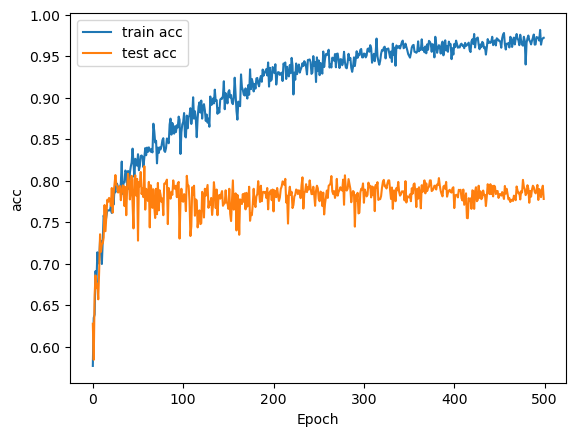

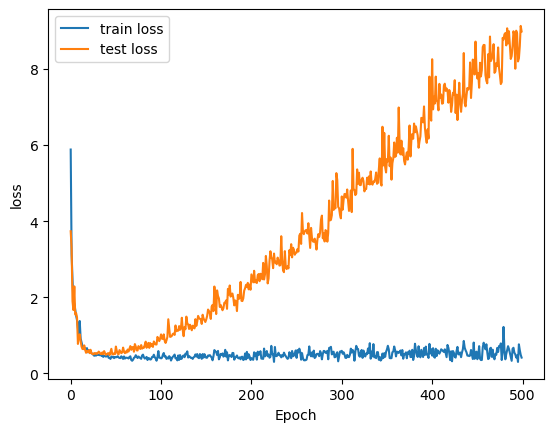

In [29]:
draw_acc_history(history)
draw_loss_history(history)

In [31]:
# model_best = EEGNET().to(device)
model_best = DeepConvNet().to(device)
model_best.load_state_dict(torch.load(f"./best.ckpt"))
model_best.eval()


with torch.no_grad():

    batch_test_acc = []
    batch_test_loss = []
    
    for batch in tqdm(test_loader):
        features, labels = batch
        labels = labels.to(device)
        test_pred = model_best(features.to(device))
        loss = criterion(test_pred, labels.long()) 
        acc = (test_pred.argmax(dim= -1)== labels).float().mean()
        batch_test_acc.append(acc)
        batch_test_loss.append(loss.item())

    test_acc = sum(batch_test_acc) / len(batch_test_acc)
    test_loss = sum(batch_test_loss) / len(batch_test_loss)

    print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")
        


  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:00<00:00, 115.18it/s]

[ Test ] loss = 0.55385, acc = 0.81740
